# Identifying Recruitment Targets with Machine Learning Models
###### By: Jordan Fortney
### Objective
A recruiting team has been tasked to hire new members for their company's Data Science department from a pool of candidates currently enrolled in a skills development program. The traditional selection process of combing through the enrollees and manually weighing all the pros and cons to decide who to target consumes a lot of time and resources and a mroe sophisticated system is needed. The recruiting team would like a model to be built that will highlight the enrollees who are most likely to be interested in a career change and therefore should be targeted for recruitment. The model must be accurate to at least 80% and focus on the recall score of it's classification to ensure as few potential candidates are slipping through as possible. The recruitment team would like a ranked list to work off of once the model is completed. The recruiting team has provided a list of enrollees that includes various pieces of information about them and whether they would be considered a target or not along with a preliminary list of enrollees that need to be classified. 

### Introduction
This project will walk through the process of building and testing various machine learning models to accomplished the objective stated above. It begins with null value treatment followed by exploratory data analysis and feature engineering. We then build and test two linear models, logistic and support vector, as well as K-nearest Neighbors, Decision Tree, Random Forrest, and finally a bagged model. Each model goes through hyperparameter optimization and some cross validation. These models are then compared based on their accuracy, precision, recall, and run time to determine the best fit for our objective. 

---

### Project Set-up and Data Inspection

#### Packages

A relatively standard suite of packages is used throughout the project including pandas, numpy, seaborn, and matplotlib. Of note would be the joblib package which is used to save the results of some cells with long processing times. Having these results saved in the project's directory severely cuts the time it takes to load the project notebook and refresh it when it is needed, all these joblib files are available in this project's GitHub repository. [Scikit Learn](https://scikit-learn.org/stable/about.html#citing-scikit-learn) is the main author used for the machine learning models and evaluation metrics throughout this project.

In [1]:
# Basic Packages
import pandas as pd
import numpy as np
import seaborn as sns
import time
import joblib
import os.path
import matplotlib.pyplot as plt

# Feature Analysis
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

#### Project Style

To keep the project's color scheme and style as coherent as possible we used Seaborn's style and palette settings. The 'darkgrid' style was used to ensure all our graphs stood out from a basic white background. The 'winter' palette (originally from matplotlib) was chosen because the two main colors are distinct while maintaining clarity.

In [2]:
# Set style and color palette for figures
sns.set_style(style = 'darkgrid')
sns.set_palette(palette = 'winter')

---
### Exploratory Data Analysis

#### Data Upload and Inspection

The original datasets were obtained from [Kaggle](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists)

Two .csv file were provided for this project, one to train and validate the models which included a target feature. The other includes enrollees that needed to be classified and does not have the targeted feature. The train dataset was constructed of 14 columns describing 19158 enrollees (rows) while the prediction dataset had 13 columns and 2129 enrollees (rows). 

At first glance it was evident that there are some missing values that will need to be treated as well as a mix of categorical and numeric columns. Before analyzing each feature's relevance and whether it required any additional processing the null values needed to be treated to get a full picture of each columns distribution and make up.

In [3]:
# Load train dataset
hrTrain = pd.read_csv('aug_train.csv')
hrTrain

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [4]:
# Load prediction dataset
hrPred = pd.read_csv('aug_test.csv')
hrPred

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15
2125,195,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,NaN,NaN,2,30
2126,31762,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18
2127,7873,city_102,0.804,Male,Has relevent experience,Full time course,High School,NaN,7,100-500,Public Sector,1,84


In [5]:
# Print dataset shapes
print('Train Dataset Shape: ', hrTrain.shape)
print('Predict Dataset Shape: ', hrPred.shape)

Train Dataset Shape:  (19158, 14)
Predict Dataset Shape:  (2129, 13)


---

#### Null Value Treatment

For this section of the project we analyzed each column for null value to make a decision on whether to fill them or drop the column completely. The training data set had more information to look at so we focused on that for the analysis and then made the same changes to the prediction dataset. 

A heatmap was made to highlight which columns were going to need the most attention and therefore had the highest chance of being dropped. We also built a table to show what percentage of values in each column were null. The columns with the most null values were: `company_type` (32.05%), `company_size` (30.99%), and `gender` (23.53%). It is likely that we drop any column with more than 30% null values but further inspection is needed before making that decision.

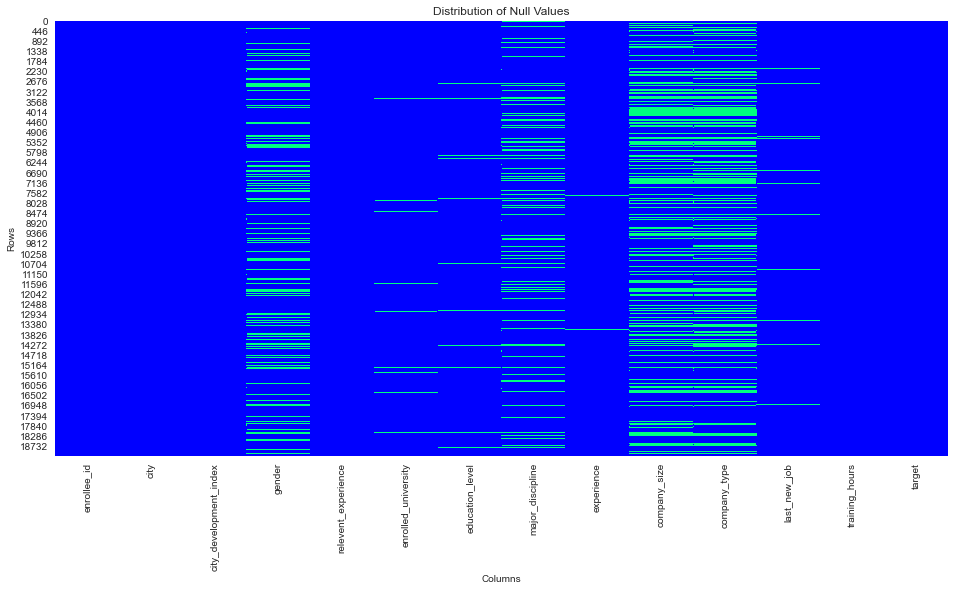

In [6]:
# Plot a heatmap displaying the distribution of null values through the train dataset columns
plt.figure(figsize= (16,8))
ax = plt.axes()
sns.heatmap(hrTrain.isnull(), cbar = False, cmap = 'winter', ax = ax)
ax.set_title('Distribution of Null Values')
ax.set_xlabel('Columns')
ax.set_ylabel('Rows')
plt.show()

In [7]:
# Create a temp dataframe for null vlaue totals
nullTotalDF = pd.DataFrame(hrTrain.isnull().sum()).reset_index()
nullTotalDF.columns = ['Category', 'Total Null']
# Create a temp dataframe for null value percentages
nullPercentDF = pd.DataFrame(round(hrTrain.isnull().sum()/hrTrain.shape[0]*100,2)).reset_index()
nullPercentDF.columns = ['Category', 'Percent Null (%)']
# Merge temporary null value datasets and sort by null percentage
nullDF = pd.merge(nullTotalDF, nullPercentDF, on = 'Category')
nullDF.sort_values('Percent Null (%)', ascending = False)

,Category,Total Null,Percent Null (%)
10,company_type,6140,32.05
9,company_size,5938,30.99
3,gender,4508,23.53
7,major_discipline,2813,14.68
6,education_level,460,2.40
11,last_new_job,423,2.21
5,enrolled_university,386,2.01
8,experience,65,0.34
0,enrollee_id,0,0.00
1,city,0,0.00


#### Null Value Treatment - Categorical Columns
Most machine learning models do not accept null values so they need to be removed or inferred prior to training. The main goal of our null value treatment is to remove all the null values throughout the dataset without deleting any rows as we would like to keep as much information as possible. In many cases while inferring data we will not be able to make a definite assumption on what the null value should be classified as so they will be binned and labeled as 'Other'.

##### Gender:
The second largest category in the `gender` column is null or in other words 'no answer'. We'll make the assumption that many people who do not identify as a male did not want to disclose that gender information and since that was not an option they left that section blank resulting in a null value. For the purpose of our model we'll change the entries in this columns from 'Male' to 'Male ID' for those who chose to identify as Male and to 'Non-Male ID' for those who did not choose to identify as male. This will result in a binary classification for the `gender` column without any null values.

In [8]:
# Display gender column value counts with nulls for the train dataset
hrTrain['gender'].value_counts(dropna = False)

Male      13221
NaN        4508
Female     1238
Other       191
Name: gender, dtype: int64

In [9]:
# Relabelling the gender entries to the desired labels
hrTrain['gender'].replace({'Male':'Male ID', 'Female':'Non-Male ID', 'Other':'Non-Male ID'}, inplace = True)
# Filling the null values for the gender column
hrTrain['gender'].fillna('Non-Male ID', inplace = True)
hrTrain['gender'].value_counts(dropna = False)

Male ID        13221
Non-Male ID     5937
Name: gender, dtype: int64

##### Enrolled University:
There are a relatively small amount of null values for whether or not the enrollee is currently enrolled in a university. We'll categorize these null values as Other.

In [10]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['enrolled_university'].value_counts(dropna = False)

no_enrollment       13817
Full time course     3757
Part time course     1198
NaN                   386
Name: enrolled_university, dtype: int64

In [11]:
# Relabel no_enrollment to a better format
hrTrain['enrolled_university'].replace({'no_enrollment':'No Enrollment'}, inplace = True)
# Filling the null values to the desired label
hrTrain['enrolled_university'].fillna('Other', inplace = True)
hrTrain['enrolled_university'].value_counts(dropna = False)

No Enrollment       13817
Full time course     3757
Part time course     1198
Other                 386
Name: enrolled_university, dtype: int64

##### Education Level:
We'll change the null values in the `education level` to 'Other' since we can't assume the education level of those who did not fill out this section.

In [12]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['education_level'].value_counts(dropna = False)

Graduate          11598
Masters            4361
High School        2017
NaN                 460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [13]:
# Filling the null values to the desired label
hrTrain['education_level'].fillna('Other', inplace = True)
hrTrain['education_level'].value_counts(dropna = False)

Graduate          11598
Masters            4361
High School        2017
Other               460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

##### Major Discipline:
We have more null values than many of the alternative options that were presented to the enrollees. We'll change this category into a binary classification where the `major_discipline` is either STEM or Non-STEM.

In [14]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['major_discipline'].value_counts(dropna = False)

STEM               14492
NaN                 2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [15]:
# Relabelling the gender entries to the desired labels
hrTrain['major_discipline'].replace(dict.fromkeys(['Humanities', 'Other', 'Business Degree', 'No Major', 'Arts'], 'Non-STEM'), inplace = True)
# Filling the null values to the desired label
hrTrain['major_discipline'].fillna('Non-STEM', inplace = True)
hrTrain['major_discipline'].value_counts(dropna = False)

STEM        14492
Non-STEM     4666
Name: major_discipline, dtype: int64

##### Experience:
There are relatively few null values for years of `experience` but simply setting these all to 'Other' like we have done with other categories does not make sense with these numeric values. Let's set them to the average of our set. This requires us to do some additional manipulation to find out what that average is since we have some non-numeric values. 

In [16]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['experience'].value_counts(dropna = False)

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
NaN      65
Name: experience, dtype: int64

In [17]:
# Calculationg the average of our years of experience

# Get list of experience values
exp = hrTrain['experience'].dropna().tolist()
# Convert non-numeric entries to numbers in string format
for i in range(0, len(exp)):
    if exp[i] == '<1':
        exp[i] = '0'
    elif exp[i] == '>20':
        exp[i] = '21'
    # Change all list entries from strings to numbers
    exp[i] = int(exp[i])
# Calculate the mean ecperience of all our enrollees
mean = round(sum(exp)/len(exp))
print("The mean years of experience is: ",mean)

The mean years of experience is:  10


In [18]:
# Set the null values to the average of our enrollee experince 
hrTrain['experience'].fillna('10', inplace = True)

The years of experience metric is little flawed as it is both very specific and very broad. This category is more useful if we use it to identify enrollees in different stages of their career not the specific number of years they have experience for. To make this categorizations more meaningful we'll bin the years into 5 year groups to see what the distribution looks like based on the stage of their career that each enrollee is in. 

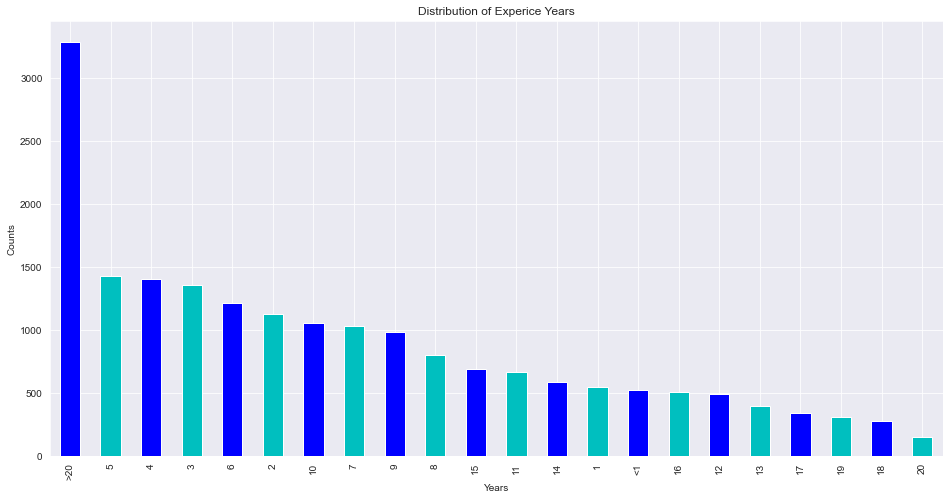

In [19]:
# Plot the distribution of experince years and their counts
plt.figure(figsize= (16,8))
ax = plt.axes()
hrTrain['experience'].value_counts().plot(kind = 'bar', ax = ax, color = {'b', 'c'})
ax.set_title('Distribution of Experice Years')
ax.set_xlabel('Years')
ax.set_ylabel('Counts')
plt.show()

In [20]:
# Binning ranges of 5 years into new categories
hrTrain['experience'].replace(dict.fromkeys(['<1', '1', '2', '3', '4'], '<5'), inplace = True)
hrTrain['experience'].replace(dict.fromkeys(['8', '9', '5', '6', '7'], '5-9'), inplace = True)
hrTrain['experience'].replace(dict.fromkeys(['10','11', '12', '13', '14'], '10-14'), inplace = True)
hrTrain['experience'].replace(dict.fromkeys(['15', '16', '17', '18', '19', '20'], '15-20'), inplace = True)
hrTrain['experience'].value_counts()

5-9      5456
<5       4955
>20      3286
10-14    3193
15-20    2268
Name: experience, dtype: int64

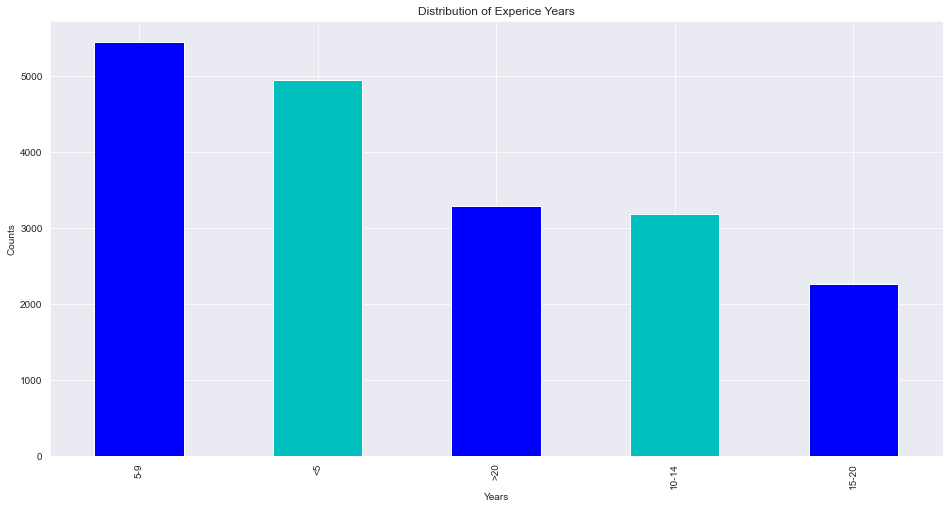

In [21]:
# Plot the distribution of experince stages and their counts
plt.figure(figsize= (16,8))
ax = plt.axes()
hrTrain['experience'].value_counts().plot(kind = 'bar', ax = ax, color = {'b', 'c'})
ax.set_title('Distribution of Experice Years')
ax.set_xlabel('Years')
ax.set_ylabel('Counts')
plt.show()

These classifications are a lot more useful and mean more to the analysis. This will also drastically reduce the number of features our models have to analyze later on int he project. 

##### Company Size:
There are more null values than any other of the numeric buckets for the `company_size` category. We cannot use an average because it is the number one category and using 'Other' isn't a valid option. We will drop the company_size category altogether.

In [22]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['company_size'].value_counts(dropna = False)

NaN          5938
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [23]:
# Droping the company size column from both datasets
hrTrain.drop(['company_size'], axis = 1, inplace = True)

##### Company Type:
We'll change the null values in the `company type` to 'Other' since we can't assume the type of those who did not fill out this section.

In [24]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['company_type'].value_counts(dropna = False)

Pvt Ltd                9817
NaN                    6140
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64

In [25]:
# Lebeled null values as 'Other'
hrTrain['company_type'].fillna('Other', inplace = True)

##### Last New Job
There are relatively few null values for the `last_new_job` and since there are no gaps in the range of options provided to the enrollees 'Other' is not a suitable option. We'll jsut set these null values to 'never'.

In [26]:
# Display enrolled_university column value counts with nulls for the train dataset
hrTrain['last_new_job'].value_counts(dropna = False)

1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
NaN       423
Name: last_new_job, dtype: int64

In [27]:
hrTrain['last_new_job'].fillna('never', inplace = True)

##### Categorical Null Value Treatment Summary:  
* Gender: Changed to binary classification of: identified as male or did not identify as male which included the null values
* Enrolled University: Null values set to 'Other'
* Education Level: Null values set to 'Other'
* Major Discipline: Changed to binary classification of: STEM or NON-STEM which included the null values
* Experience: Null values were set to the average of the train dataset. Values were then binned into 5 year groups.
* Company Size: Dropped from the dataset
* Company Type: Null values set to 'Other'
* Last New Job: Null values set to 'never'

In [28]:
# Post treatment null value counts
hrTrain.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

### Additional Column Analysis
`Enrollee_id` is a unique identifier and therefore not useful for modeling which means it can be dropped. `City` doesn't really affect our objective and it is very likely that we run into a future enrollee that does not work in one of the 123 cites from the original dataset. This will cause issues at some point so we will remove it from the dataset. `relevent_experience` does not need any changes at this time.

In [29]:
# Drop enrollee id column
hrTrain.drop('enrollee_id', axis = 1, inplace = True)
# Drop city column
hrTrain.drop('city', axis = 1, inplace = True)

--- 
### Univariate Analysis
The next step we took is to write a function to create some simple charts for univariate analysis. This function will take a column name and output two charts. The first compares the number of targets and non-targets for each unique value within a column. The second chart compares the percentage of targeted enrollees within each individual value. This will help normalize the counts from the first chart which may be misleading due to any potential volume imbalance. These two charts will tell us where targeted enrollees are most commonly found and where they are most likely found.   

In [30]:
# Function to produce two charts for univariate analysis
def univar(dataset, column, width = 0.2):
    # Create list variable for the function
    labels = np.unique(dataset[column].tolist())
    targetList = []
    nonTargetList = []
    percents = []
    width = width
    labelLen = np.arange(len(labels))

    # For loop to separate each unique value and the recruitment potential
    for i in labels:
        # Make list of all rows with a unique value and is a target
        colCountTarget = len(dataset.loc[(dataset[column] == i) & (dataset['target'] == 1)])
        targetList.append(colCountTarget)
        # Make list of all rows with a unique value and is not a target
        colCountNotTarget = len(dataset.loc[(dataset[column] == i) & (dataset['target'] == 0)])
        nonTargetList.append(colCountNotTarget)
        # Make a list of percentage target for each unique value
        perCol = round(colCountTarget/(colCountTarget+colCountNotTarget)*100,2)
        percents.append(perCol)
    
    # Subplot set up and features
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    fig.suptitle(f'Univariate Analysis of {str(column).title()}')
    
    # ax1 - Double bar chart for targeted and non-targeted counts for unique values
    ax1.bar(labelLen - width/2, targetList, width, label = 'Target', edgecolor = 'black', color = 'c')
    ax1.bar(labelLen + width/2, nonTargetList, width, label = 'Non-Target', edgecolor = 'black', color = 'b')
    # ax1 - Graph elements
    ax1.set_ylabel('Number of Enrollees')
    ax1.set_xlabel(str(column).title())
    ax1.set_title(f'Total Enrollee Target Comparison by {str(column).title()}')
    ax1.set_xticks(labelLen)
    ax1.set_xticklabels(labels, rotation = 15)
    ax1.legend()
    
    # ax2 - Bar cahrt for percent targeted by each unique value
    ax2.bar(labels, percents, edgecolor = 'black', color = {'c', 'b'})
    # ax2 - Graph elements
    ax2.set_ylabel('Percent Targeted (%)')
    ax2.set_xlabel(str(column).title())
    ax2.set_title(f'Enrollee Percent Targeted Comparison by {str(column).title()}')
    ax2.set_xticklabels(labels, rotation = 15)
    
    plt.show()

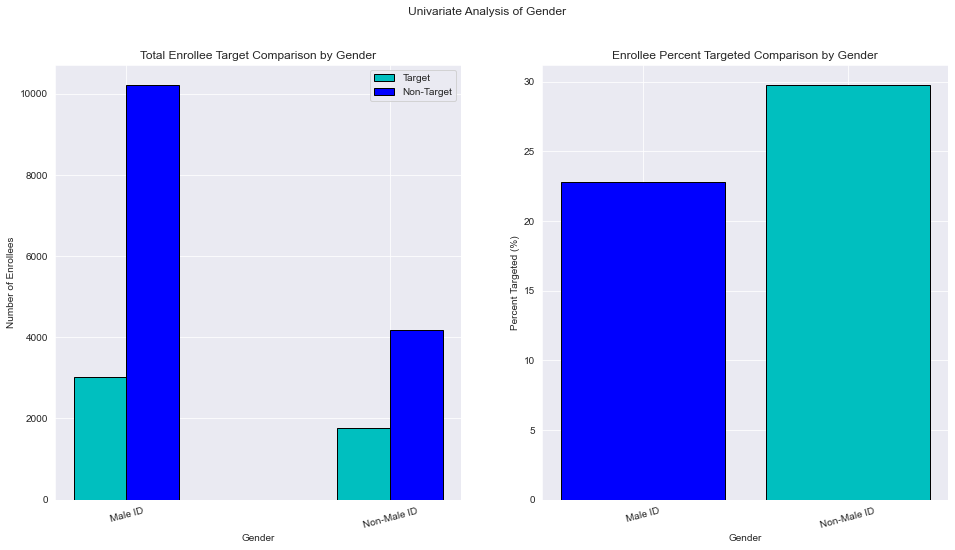

In [31]:
univar(hrTrain,'gender')

We can see that there are more total targets who are male identifying but an enrollee that is non-male identifying is more likely to be a target by roughly 7%.

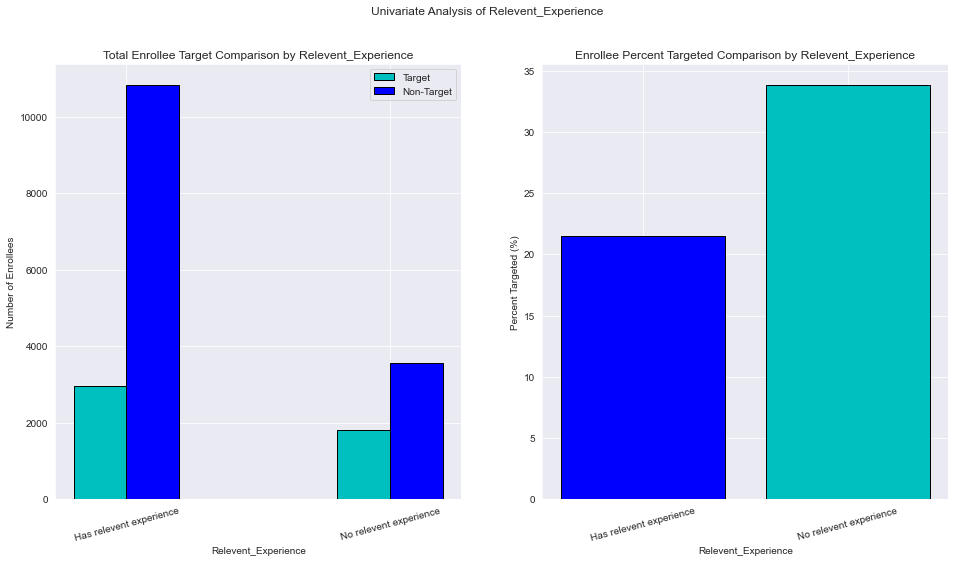

In [32]:
univar(hrTrain,'relevent_experience')

We can see that there are more total targets who have relevant experience but an enrollee that has no relevant experience is more likely to be a target by roughly 12%.

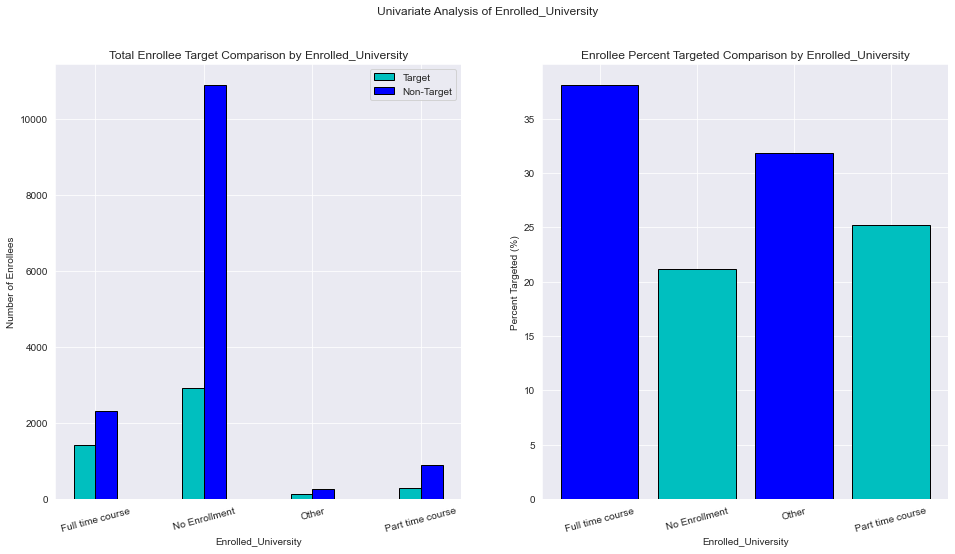

In [33]:
univar(hrTrain,'enrolled_university')

Enrollees with no enrollment in a university are the most common recruitment targets but those enrolled full time are targeted most per capita followed by Other by roughly 6%.

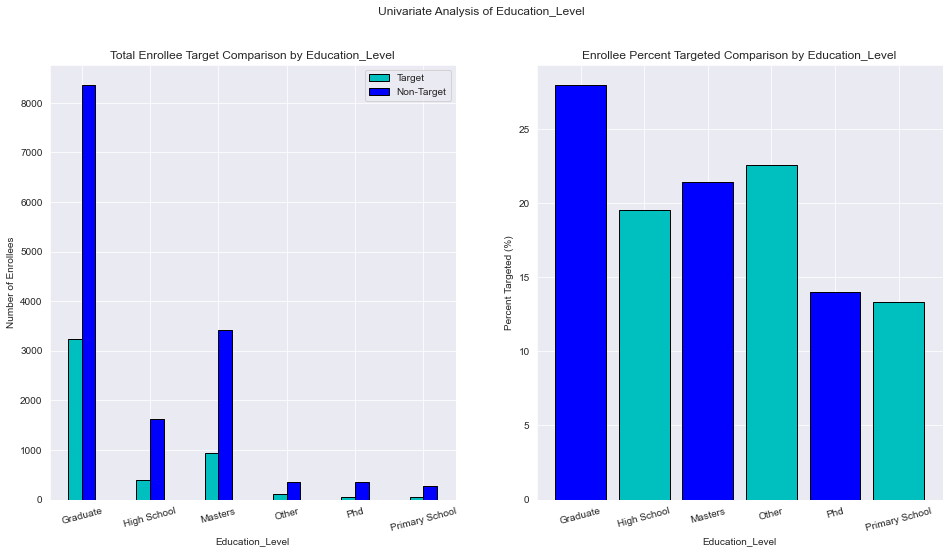

In [34]:
univar(hrTrain,'education_level')

Enrollees with a Graduate education level are both the most common and most likely target for recruitment.

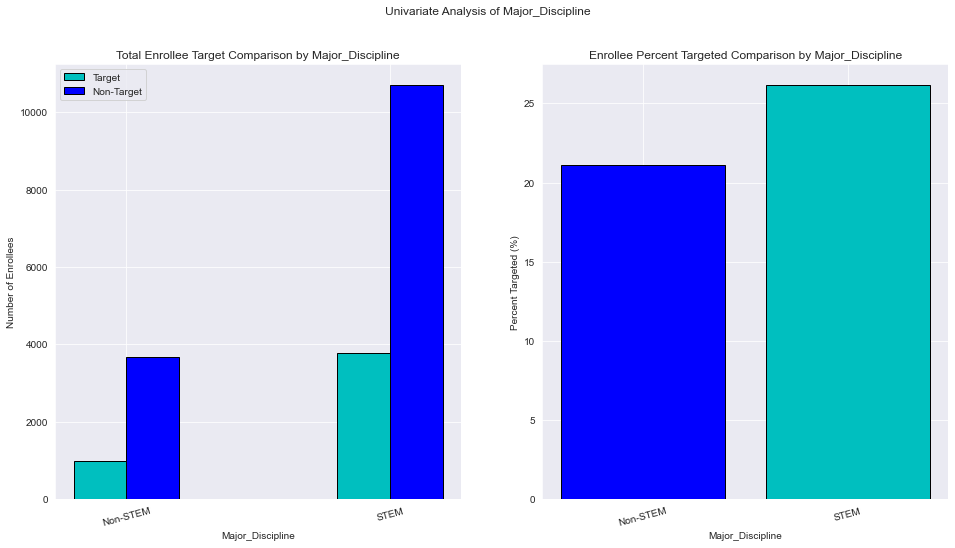

In [35]:
univar(hrTrain,'major_discipline')

Enrollees who majored in a STEM are the most common and most likely recruitment targets. 

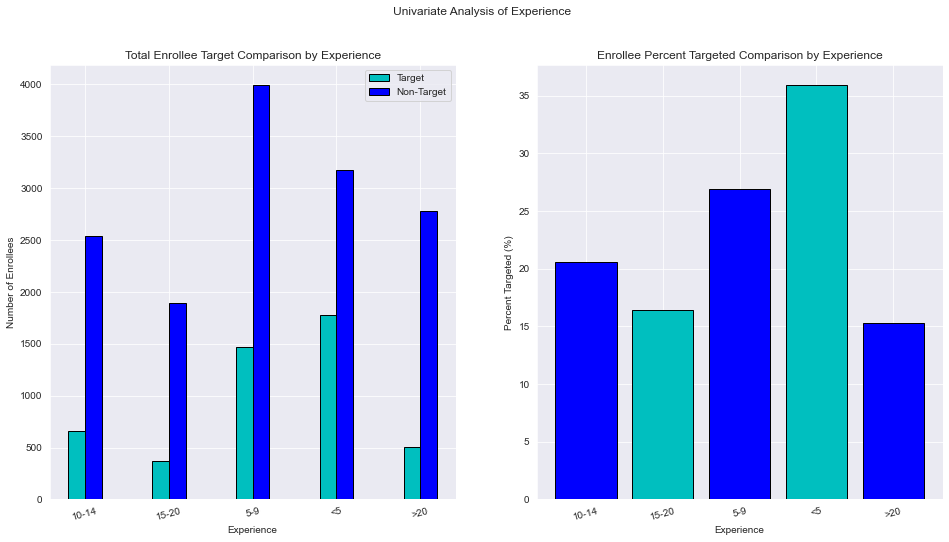

In [36]:
univar(hrTrain,'experience')

Enrollees who have less than 5 years of experience are the most common and most likely recruitment targets.

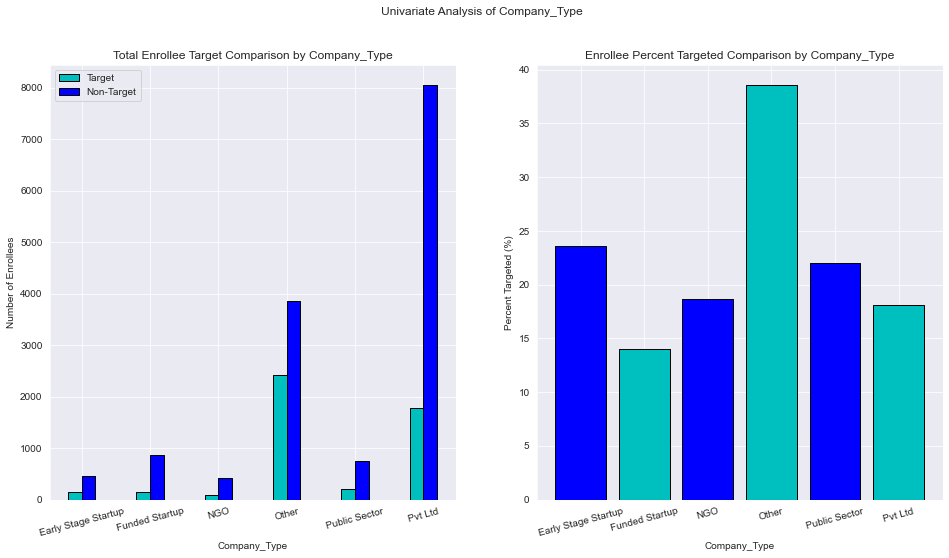

In [37]:
univar(hrTrain,'company_type')

Enrollees who's current employer does not fit into one of the generic options (i.e. Other) are the most common and most likely to be recruitment targets. 

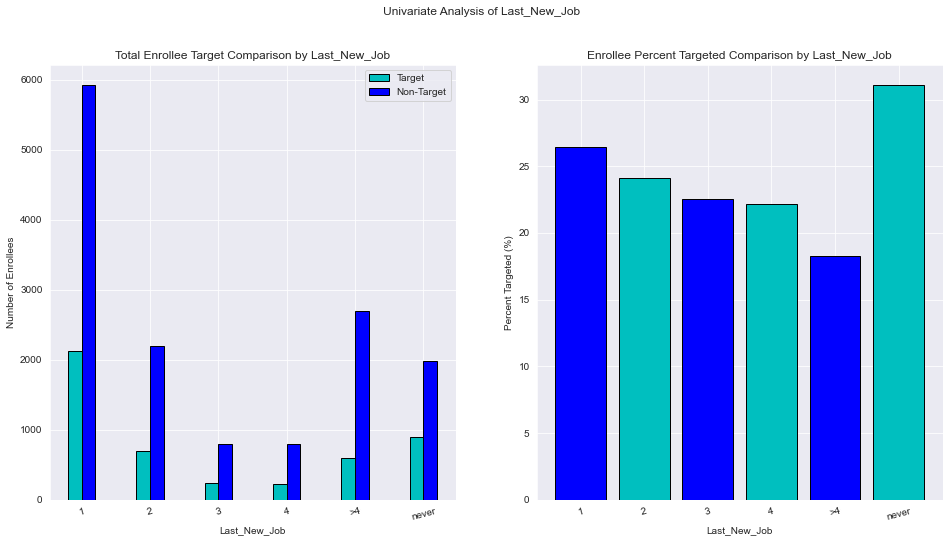

In [38]:
univar(hrTrain,'last_new_job')

Enrollees with 1 year since their last job are the most common recruitment target but those who have never changed jobs are the most likely by roughly 5%.

---
#### Numeric Category Analysis
The distribution and quantiles of the numeric columns were analyzed and their outliers were checked and treated if necessary. 
##### City Development Index:
The majority of enrollees are found in cities with a development index above 0.9. The median of those who are not a recruitment target is much higher, just over 0.9, than those who are targets which sits around 0.7. There is also a much tighter interquartile range for the non-targeted enrollees which indicates the city development index is less variable for those who are not targeted. There are some "outliers" in this metric according to the boxplot below but since the city development index is a qualitative metric we shouldn't be capping them in our analysis.

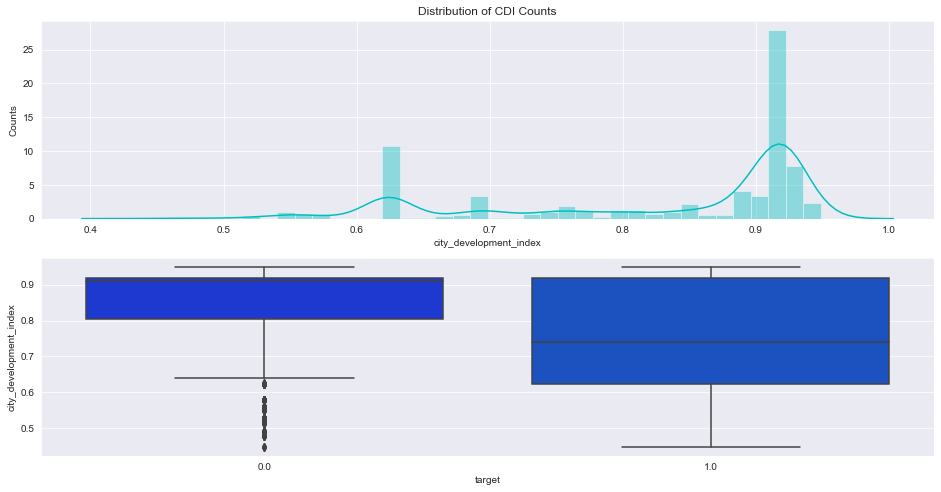

In [39]:
# Distribution and boxplot charts
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
ax1 = sns.distplot(hrTrain['city_development_index'], color = 'c')
ax1.set(title = 'Distribution of CDI Counts', ylabel = 'Counts')
plt.subplot(2,1,2)
ax2 = sns.boxplot(y = hrTrain['city_development_index'], x = hrTrain['target'])
plt.show()

##### Training Hours:
We can see that the distribution of training hours is much more typical for numeric metrics although it is skewed. We can see a large number of glaring outliers for both the target and non-target groups. We'll cap these outliers at the 95th percentile so they do not interfere with out model outputs.

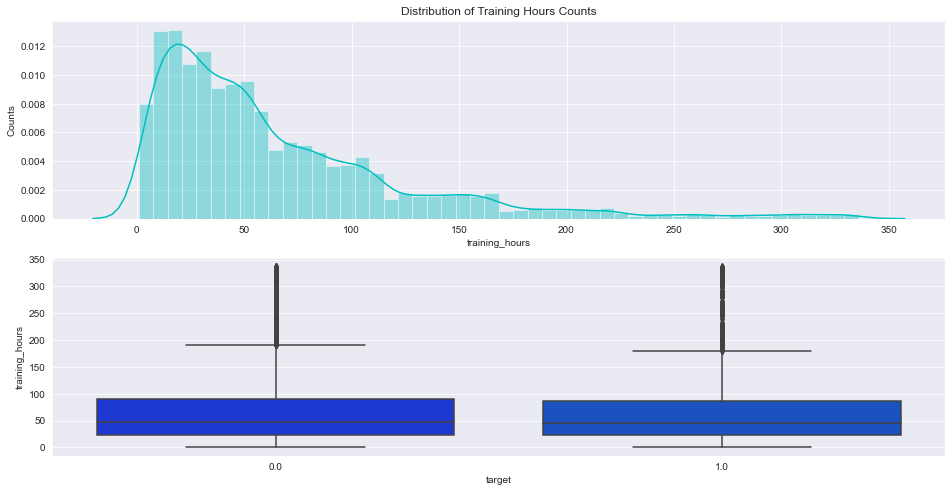

In [40]:
# Distribution and boxplot charts
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
ax1 = sns.distplot(hrTrain['training_hours'], color = 'c')
ax1.set(title = 'Distribution of Training Hours Counts', ylabel = 'Counts')
plt.subplot(2,1,2)
sns.boxplot(y = hrTrain['training_hours'], x = hrTrain['target'])
plt.show()

In [41]:
# Change any values above the 95th percentile equal to the 95th percentile
q95 = hrTrain['training_hours'].quantile(0.95)
hrTrain.loc[hrTrain['training_hours'] >= q95, 'training_hours'] = q95

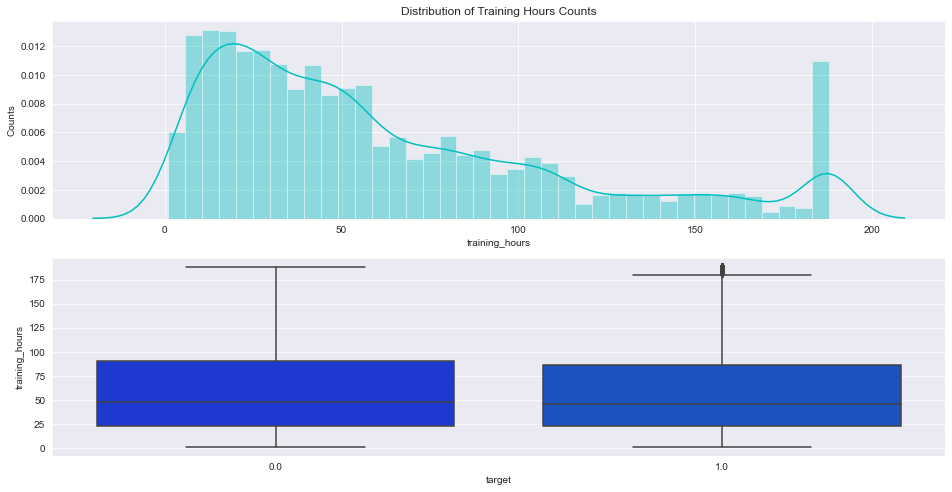

In [42]:
# Distribution and boxplot charts
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
ax1 = sns.distplot(hrTrain['training_hours'], color = 'c')
ax1.set(title = 'Distribution of Training Hours Counts', ylabel = 'Counts')
plt.subplot(2,1,2)
sns.boxplot(y = hrTrain['training_hours'], x = hrTrain['target'])
plt.show()

##### Targets:
Finally we can take a look at the Target, with a 3:1 ratio between targeted enrollees and non-targeted our dataset is clearly unbalanced and we will have to do some some re-sampling to even it out.

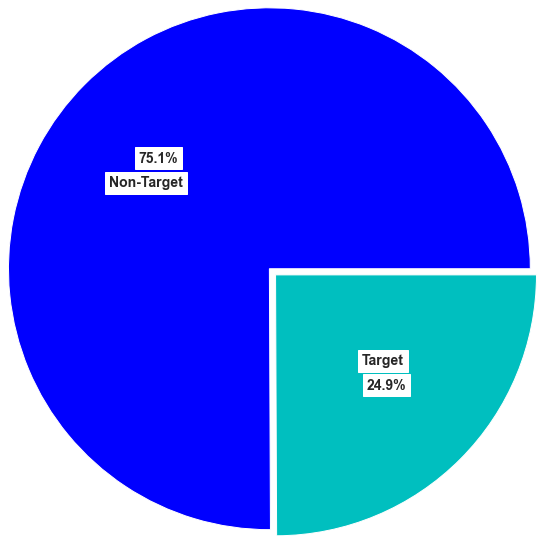

In [43]:
# Plot target distribution
targetCounts = hrTrain['target'].value_counts().to_frame('counts')
plt.figure()
plt.pie(targetCounts.counts, explode = (0, 0.1), labels = ['Target', 'Non-Target'], autopct='%1.1f%%', radius = 3, labeldistance = -0.5, colors = ['b', 'c'], textprops={'fontsize': 14, 'backgroundcolor': 'w', 'weight': 'bold'})
plt.show()

##### Summary:
Based on the univariate analysis we would expect our targets to most likely have the following features:
* Gender: Non-Male Identifying
* Experience: No relevant experience
* University Enrollment: Full Time
* Education Level: Graduate
* Major: STEM
* Experience: <5 years
* Company Type: Other
* Last New Job: Never
* City Development Index: Average ~0.7
* Training Hours: Average ~50

If we check the dataset there are actually no enrollees who fit this profile perfectly. All the qualifications of the enrollee will have to be weighted and then their pros and cons compared to decide whether or not an enrollee should be targeted. Machine learning models do this very well and very quickly for large datasets but before the we can build and test those models there needs to be some additional data manipulation.

In [44]:
hrTrain.loc[(hrTrain['gender'] == 'Non-Male ID') & 
            (hrTrain['experience'] == 'No relevent experience') & 
            (hrTrain['enrolled_university'] == 'Full time course') & 
            (hrTrain['education_level'] == 'Full time Graduate') &
            (hrTrain['major_discipline'] == 'STEM') & 
            (hrTrain['experience'] == '<5') & 
            (hrTrain['company_type'] == 'Other') &
            (hrTrain['last_new_job'] == 'never') &
            ((hrTrain['city_development_index'] >= 0.65) & (hrTrain['city_development_index'] <= 0.75)) & 
            ((hrTrain['training_hours'] >= 40) & (hrTrain['training_hours'] <= 60))]

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_type,last_new_job,training_hours,target


---
### Dataset Conversion Function
We have done quite a bit of data manipulation and trimming on the train dataset. This needs to be replicated on the predict dataset so it will properly fit into our final model. Building this function will also allow us to quickly process any new datasets we are presented with in the future.

In [45]:
def dataPrep(dataset):
    # Relabelling the gender entries to the desired labels
    dataset['gender'].replace({'Male':'Male ID', 'Female':'Non-Male ID', 'Other':'Non-Male ID'}, inplace = True)
    # Filling the null values for the gender column
    dataset['gender'].fillna('Non-Male ID', inplace = True)
    
    # Relabel no_enrollment to a better format
    dataset['enrolled_university'].replace({'no_enrollment':'No Enrollment'}, inplace = True)
    # Filling the null values to the desired label
    dataset['enrolled_university'].fillna('Other', inplace = True)

    # Filling the null values to the desired label
    dataset['education_level'].fillna('Other', inplace = True)
    dataset['education_level'].value_counts(dropna = False)
    
    # Relabelling the gender entries to the desired labels
    dataset['major_discipline'].replace(dict.fromkeys(['Humanities', 'Other', 'Business Degree', 'No Major', 'Arts'], 'Non-STEM'), inplace = True)
    # Filling the null values to the desired label
    dataset['major_discipline'].fillna('Non-STEM', inplace = True)
    
    # Binning ranges of 5 years into new categories
    dataset['experience'].fillna('10', inplace = True)
    dataset['experience'].replace(dict.fromkeys(['<1', '1', '2', '3', '4'], '<5'), inplace = True)
    dataset['experience'].replace(dict.fromkeys(['8', '9', '5', '6', '7'], '5-9'), inplace = True)
    dataset['experience'].replace(dict.fromkeys(['10','11', '12', '13', '14'], '10-14'), inplace = True)
    dataset['experience'].replace(dict.fromkeys(['15', '16', '17', '18', '19', '20'], '15-20'), inplace = True)
    
    # Droping the company size column from both datasets
    dataset.drop(['company_size'], axis = 1, inplace = True)
    
    # Lebeled null values as 'Other'
    dataset['company_type'].fillna('Other', inplace = True)
    
    # Lebeled null values as 'Other'
    dataset['last_new_job'].fillna('never', inplace = True)
    
    # Drop city column
    dataset.drop('city', axis = 1, inplace = True)

    # Change any values above the 95th percentile equal to the 95th percentile
    q95 = dataset['training_hours'].quantile(0.95)
    dataset.loc[dataset['training_hours'] >= q95, 'training_hours'] = q95
    
    # Scale numeric columns
    scaler = StandardScaler()
    data = dataset[['city_development_index', 'training_hours']]
    dataset[['city_development_index', 'training_hours']] = scaler.fit_transform(data)

In [46]:
dataPrep(hrPred)

---
### Pre-model Preparation
Now that our data has been cleaned and reformatted we need to ensure that it is digestable by our models. This means converting the numeric columns so that they fall within the same scale and converting all our categories into binary values (0 or 1), also known as dummy variables. We then need to deal with the class imbalance that we have between the targeted and non-targeted enrollees. Finally we'll look at the correlation of our variables and run recursive feature elimination to reduce the number of trainable features and ideally the correlation. 

##### Standard Scaling:
These numeric columns need to be scaled to be properly incorporated into some of our models since they are quite different in their value ranges. Scaling these numbers will distribute each column so that the mean of the values is 0 and the standard deviation is 1.

In [47]:
scaler = StandardScaler()
data = hrTrain[['city_development_index', 'training_hours']]
hrTrain[['city_development_index', 'training_hours']] = scaler.fit_transform(data)

##### Dummy Variables:
The purpose of creating dummy variables is to transform our nominal values into numbers so that they can be used in regression and oversampling methods. This function transforms each column into a multiple columns each representing a unique value and then filling that column with a binary number. For example the `gender` column is transformed into `gender - Male ID` and `gender - Non-Male ID`. If the enrollee originally had a `gender` of 'Male ID' their dummy variables would be 1 int he new `gender - Male ID` column and 0 in the new `gender - Non-Male ID`. We end up up with many more columns this way (11 columns turn into 28) but the amount of information does not change. It is also very common practice to drop the first of these new dummy columns. This helps reduce the number columns because one will always be irrelevant through process of elimination. Having two binary columns that are exactly opposite from each other provides the same information as having one of those two binary columns.

In [48]:
# Display dataset before dummy variables
hrTrain

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_type,last_new_job,training_hours,target
0,0.738919,Male ID,Has relevent experience,No Enrollment,Graduate,STEM,>20,Other,1,-0.520598,1.0
1,-0.428410,Male ID,No relevent experience,No Enrollment,Graduate,STEM,15-20,Pvt Ltd,>4,-0.302901,0.0
2,-1.660590,Non-Male ID,No relevent experience,Full time course,Graduate,STEM,5-9,Other,never,0.409564,0.0
3,-0.323026,Non-Male ID,No relevent experience,Other,Graduate,Non-STEM,<5,Pvt Ltd,never,-0.203947,1.0
4,-0.501368,Male ID,Has relevent experience,No Enrollment,Masters,STEM,>20,Funded Startup,4,-1.074738,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19153,0.398448,Male ID,No relevent experience,No Enrollment,Graduate,Non-STEM,10-14,Other,1,-0.401854,1.0
19154,0.738919,Male ID,Has relevent experience,No Enrollment,Graduate,STEM,10-14,Other,4,-0.203947,1.0
19155,0.738919,Male ID,Has relevent experience,No Enrollment,Graduate,STEM,>20,Pvt Ltd,4,-0.362273,0.0
19156,-0.217642,Male ID,Has relevent experience,No Enrollment,High School,Non-STEM,<5,Pvt Ltd,2,0.686634,0.0


In [49]:
# Convert and Dispolay datasets with dummy variables
hrTrain = pd.get_dummies(hrTrain, drop_first = True)
hrPred = pd.get_dummies(hrPred, drop_first = True)
hrTrain

,city_development_index,training_hours,target,gender_Non-Male ID,relevent_experience_No relevent experience,enrolled_university_No Enrollment,enrolled_university_Other,enrolled_university_Part time course,education_level_High School,education_level_Masters,...,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.738919,-0.520598,1.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,-0.428410,-0.302901,0.0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-1.660590,0.409564,0.0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,-0.323026,-0.203947,1.0,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,-0.501368,-1.074738,0.0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,0.398448,-0.401854,1.0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
19154,0.738919,-0.203947,1.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
19155,0.738919,-0.362273,0.0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
19156,-0.217642,0.686634,0.0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0


##### Oversampling: SMOTE
We currently have an imbalanced dataset with 3 times the amount of non-targeted enrollees. This can potentially cause issues for our models as they may not have enough examples of what a target worthy enrollee "looks" like to accurately predict them. To balance our set out we will use an oversampling technique known as SMOTE (Synthetic Minority Oversampling TEchnique) to artificially create more targeted enrollees. This could be done by simply duplicating the targeted enrollees we already have to balance the dataset but the SMOTE function is more nuanced and has shown to [improve results](https://arxiv.org/abs/1106.1813). SMOTE functions by "drawing a line" between two of the minority features and then synthesizes a new record from a point along that line. Using SMOTE we were able to increase the number of targeted enrollee samples from 4777 to 14381 to match the number of non-targeted enrollees.

In [50]:
# Set independent and dependent variables
X = hrTrain.drop(['target'], axis = 1)
Y = pd.DataFrame(hrTrain['target'])

# Build SMOTE function and fit variables for resampling
overSample = SMOTE(random_state = 12)
Xsm, Ysm = overSample.fit_resample(X, Y)

Before resampling there were 14381 NON_TARGETTED enrollees
Before resampling there were 4777 TARGETTED enrollees
After resampling there were 14381 NON_TARGETTED enrollees
After resampling there were 14381 TARGETTED enrollees


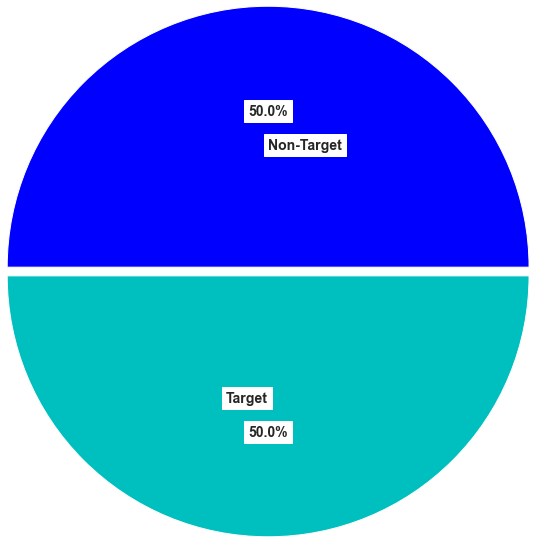

In [51]:
# Print totals before and after resampling
print(f"Before resampling there were {len(Y.loc[(Y['target'] == 0.0)])} NON_TARGETTED enrollees")
print(f"Before resampling there were {len(Y.loc[(Y['target'] == 1.0)])} TARGETTED enrollees")
print(f"After resampling there were {len(Ysm.loc[(Ysm['target'] == 0.0)])} NON_TARGETTED enrollees")
print(f"After resampling there were {len(Ysm.loc[(Ysm['target'] == 1.0)])} TARGETTED enrollees")

# Plot target distribution after resampling
targetCountsSM = Ysm['target'].value_counts()
plt.pie(targetCountsSM, explode = (0, 0.1), labels = ['Target', 'Non-Target'], autopct='%1.1f%%', radius = 3, labeldistance = -0.5, colors = ['b', 'c'], textprops={'fontsize': 14, 'backgroundcolor': 'w', 'weight': 'bold'})
plt.show()

#### Correlation and Recursive Feature Reduction:
The correlation between two features describes how much they are influenced by each other. It is important to try and reduce the number of highly correlated features because the model has a more difficult time measuring the relationship between highly correlated features and the dependent (target) variable. Typically we consider any correlation above +/- 0.5 to be [highly correlated](https://www.statisticssolutions.com/pearsons-correlation-coefficient/). Our dataset currently has 27 different features and some of those features are moderate to highly correlated with each other, as shown in the figure and table below. Features that are highly correlated need to be removed from the dataset to achieve the best results from our model. This could be done manually or we can apply recursive feature reduction (RFE) to find the optimal set of features to use.

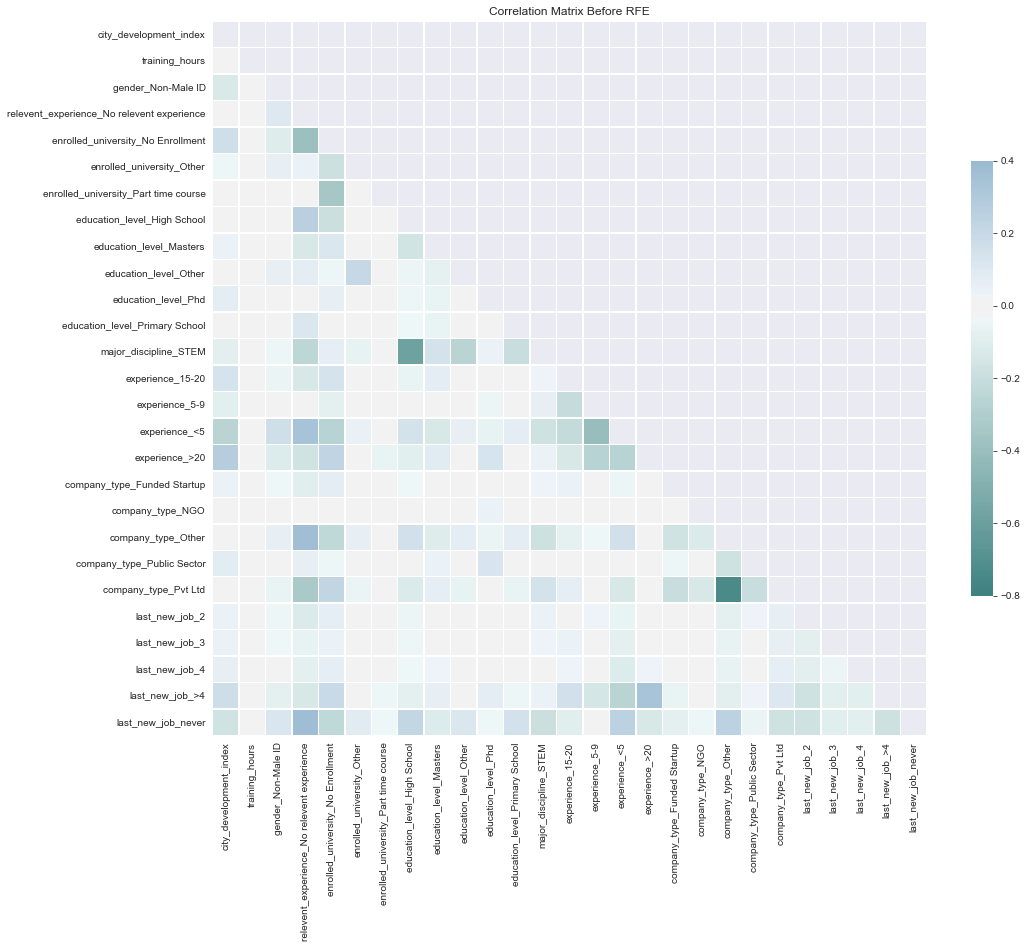

In [52]:
# Plot correlation matrix before RFE
corr = Xsm.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(190, 240, as_cmap=True)

plt.figure(figsize = (16,16))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax = 0.4, vmin = -0.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Before RFE')
plt.show()

In [53]:
# Build and display feature pairs and their correlations
corrTrain = Xsm.corr()
corrDF = corrTrain.unstack().reset_index()
corrDF.columns = ['VAR1', 'VAR2', 'Correlation']
# Drop the columns where both the feature names are the same. 
corrDF = corrDF[corrDF.Correlation != 1.0]
corrDF = corrDF[corrDF.Correlation != -1.0]
corrDF.sort_values(by='Correlation', ascending=False, inplace=True)
corrDF

,VAR1,VAR2,Correlation
107,relevent_experience_No relevent experience,last_new_job_never,0.372734
705,last_new_job_never,relevent_experience_No relevent experience,0.372734
100,relevent_experience_No relevent experience,company_type_Other,0.369655
516,company_type_Other,relevent_experience_No relevent experience,0.369655
96,relevent_experience_No relevent experience,experience_<5,0.347222
...,...,...,...
419,experience_<5,experience_5-9,-0.409446
201,education_level_High School,major_discipline_STEM,-0.582900
331,major_discipline_STEM,education_level_High School,-0.582900
534,company_type_Other,company_type_Pvt Ltd,-0.734875


In [54]:
# Build estimator with logit reg and fit resampled variables
estimator = LogisticRegression()
selector = RFECV(estimator, step = 1, cv = 10)
selector = selector.fit(Xsm, Ysm)

In [55]:
# List of kept columns after rfe
Xsm.columns[selector.support_]

Index(['city_development_index', 'enrolled_university_No Enrollment',
       'enrolled_university_Other', 'enrolled_university_Part time course',
       'education_level_High School', 'education_level_Masters',
       'education_level_Other', 'education_level_Phd',
       'education_level_Primary School', 'company_type_Funded Startup',
       'company_type_NGO', 'company_type_Public Sector',
       'company_type_Pvt Ltd', 'last_new_job_never'],
      dtype='object')

In [56]:
# List of removed columns after rfe
Xsm.columns[~selector.support_]

Index(['training_hours', 'gender_Non-Male ID',
       'relevent_experience_No relevent experience', 'major_discipline_STEM',
       'experience_15-20', 'experience_5-9', 'experience_<5', 'experience_>20',
       'company_type_Other', 'last_new_job_2', 'last_new_job_3',
       'last_new_job_4', 'last_new_job_>4'],
      dtype='object')

The RFE uses a selector model, we chose a logistic regression, to iterate through different combinations of features removing the worst performing feature at each iteration. The RFE reduced the number of features in our data set from 27 to 14 and drastically reduced the high and moderate correlations throughout the dataset. This will make it much easier for our model to measure changes in the relationships between our dependent and independent variables.  

In [57]:
# Printing before and after shapes
print(f"Before RFE: {Xsm.shape}")
# Droping columns suggested by the rfe
Xrfe = Xsm.drop(Xsm.columns[~selector.support_], axis = 1)
hrPred = hrPred.drop(Xsm.columns[~selector.support_], axis = 1)
print(f"After RFE: {Xrfe.shape}")

Before RFE: (28762, 27)
After RFE: (28762, 14)


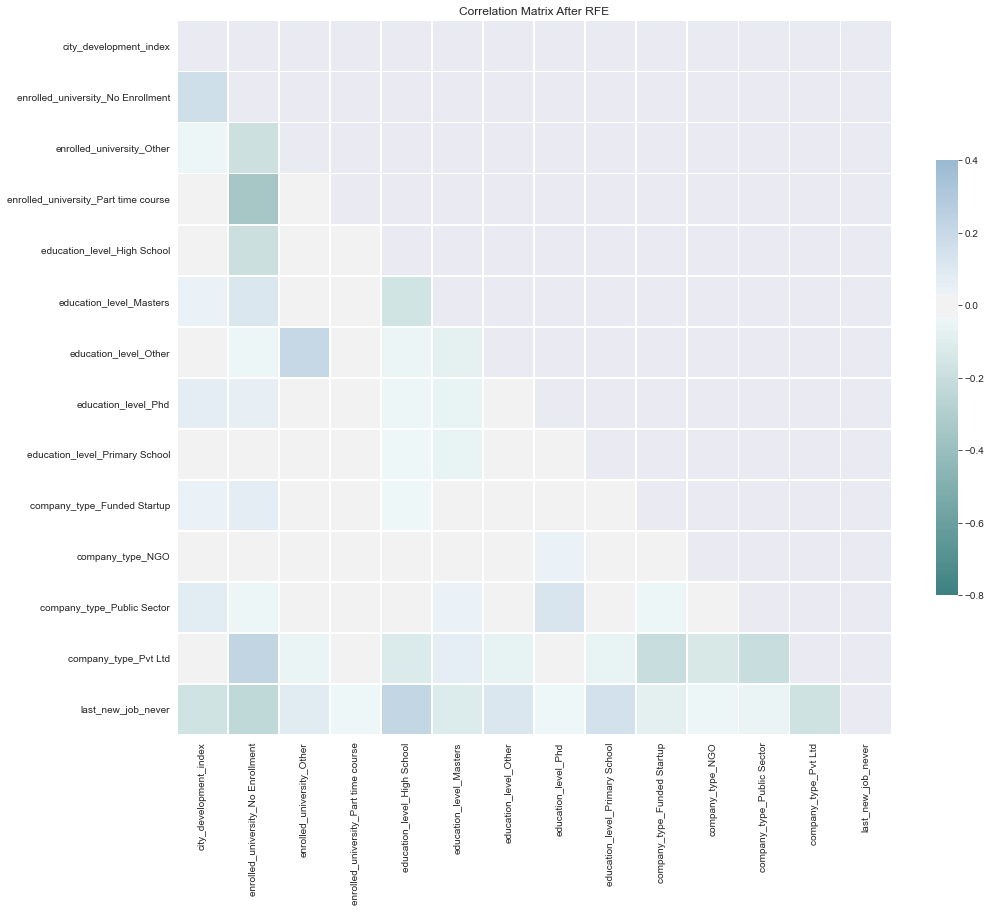

In [58]:
# Correlation Matrix after rfe
corr = Xrfe.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(190, 240, as_cmap=True)

plt.figure(figsize = (16,16))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, vmin = -0.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix After RFE')
plt.show()

In [59]:
# Build and display feature pairs and their correlations
corrTrain = Xrfe.corr()
corrDF = corrTrain.unstack().reset_index()
corrDF.columns = ['VAR1', 'VAR2', 'Correlation']
corrDF = corrDF[corrDF.Correlation != 1.0]
corrDF = corrDF[corrDF.Correlation != -1.0]
corrDF.sort_values(by='Correlation', ascending=False, inplace=True)
corrDF

,VAR1,VAR2,Correlation
26,enrolled_university_No Enrollment,company_type_Pvt Ltd,0.224329
169,company_type_Pvt Ltd,enrolled_university_No Enrollment,0.224329
69,education_level_High School,last_new_job_never,0.217784
186,last_new_job_never,education_level_High School,0.217784
34,enrolled_university_Other,education_level_Other,0.209464
...,...,...,...
166,company_type_Public Sector,company_type_Pvt Ltd,-0.198925
183,last_new_job_never,enrolled_university_No Enrollment,-0.234060
27,enrolled_university_No Enrollment,last_new_job_never,-0.234060
43,enrolled_university_Part time course,enrolled_university_No Enrollment,-0.345394


---
### Machine Learning Models
There are advantages and disadvantages to every type of model and some will be inherently better than others based on the data being analyzed and the metrics it will be evaluated by. We will build, optimize, and compare: Logistic regression, Support Vector Classification, K-Nearest Neighbors, Decision Tree, Random Forest, and then a bagged model that combines the K-Nearest Neighbors and Decision Tree models. 

#### Logistic Regression:
Just for experiment sake we'll run the logistic regression on both the feature reduced dataset as well as the dataset without feature reduction. We'll compare the p-values of each feature as well as the variance inflation factor to measure the multicollinearity of those features. 

In [60]:
# Simple function to add a constant, build and fit the data, displ;ay the summary 
def buildLogit(X, Y):
    X_const = sm.add_constant(X)
    hrModel = sm.Logit(Y, X_const).fit()
    display(hrModel.summary())
    return hrModel

In [61]:
# Simple function to display the variance inlfation factor for each model
def buildVIF(X):
    vif = pd.DataFrame()
    vif['Category'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif.sort_values(by='VIF', ascending = False, inplace=True)
    return vif

In [62]:
# Logistic regression with the non-reduced dataset
x1 = Xsm
hrModel1 = buildLogit(x1, Ysm)

Optimization terminated successfully.
         Current function value: 0.553410
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                28762
Model:                          Logit   Df Residuals:                    28734
Method:                           MLE   Df Model:                           27
Date:                Mon, 08 Mar 2021   Pseudo R-squ.:                  0.2016
Time:                        13:19:31   Log-Likelihood:                -15917.
converged:                       True   LL-Null:                       -19936.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          1.6377      0.092     17.804      0.000       1.457       1.818
city_development_index                        -0.7658      0.015    -52.402      0.000      -0.794      -0.737
training_hours                                -0.0810      0.014     -5.766      0.000      -0.108      -0.053
gender_Non-Male ID                            -0.1032      0.030     -3.386      0.001      -0.163      -0.043
relevent_experience_No relevent experience     0.1358      0.038      3.558      0.000       0.061       0.211
enrolled_university_No Enrollment             -0.5685      0.038    -15.078      0.000      -0.642      -0.495
enrolled_university_Other                     -1.0953      0.114     -9.575      0.000      -1.319      -0.871
enrolled_university_Part time course          -0.8878      0.066    -13.428      0.000      -1.017      -0.758
education_level_High School                   -1.5100      0.065    -23.146      0.000      -1.638      -1.382
education_level_Masters                       -0.4852      0.035    -13.836      0.000      -0.554      -0.416
education_level_Other                         -1.6053      0.112    -14.392      0.000      -1.824      -1.387
education_level_Phd                           -0.9160      0.128     -7.152      0.000      -1.167      -0.665
education_level_Primary School                -2.2713      0.156    -14.546      0.000      -2.577      -1.965
major_discipline_STEM                         -0.3457      0.045     -7.739      0.000      -0.433      -0.258
experience_15-20                              -0.4274      0.055     -7.788      0.000      -0.535      -0.320
experience_5-9                                -0.2260      0.042     -5.437      0.000      -0.307      -0.145
experience_<5                                 -0.0860      0.045     -1.901      0.057      -0.175       0.003
experience_>20                                -0.3264      0.051     -6.449      0.000      -0.426      -0.227
company_type_Funded Startup                   -1.3714      0.096    -14.277      0.000      -1.560      -1.183
company_type_NGO                              -1.3399      0.120    -11.208      0.000      -1.574      -1.106
company_type_Other                             0.3535      0.070      5.054      0.000       0.216       0.491
company_type_Public Sector                    -0.5579      0.092     -6.072      0.000      -0.738      -0.378
company_type_Pvt Ltd                          -0.9026      0.069    -13.171      0.000      -1.037      -0.768
last_new_job_2                                -0.2366      0.042     -5.687      0.000      -0.318      -0.155
last_new_job_3                                -0.3341      0.067     -4.957      0.000      -0.466      -0.202
last_new_job_4                                -0.3569      0.069     -5.151      0.000      -0.493      -0.221
last_new_job_>4       

In [63]:
buildVIF(x1)

,Category,VIF
21,company_type_Pvt Ltd,6.53
12,major_discipline_STEM,6.48
19,company_type_Other,5.47
4,enrolled_university_No Enrollment,4.33
15,experience_<5,2.89
14,experience_5-9,2.49
3,relevent_experience_No relevent experience,2.25
16,experience_>20,1.97
7,education_level_High School,1.80
25,last_new_job_>4,1.65


Out of all the features there is only one with a p-value greater than 0.05 that should be removed. There are also 4 features with a VIF over 3 which is a typical cut off for that metric.

In [64]:
x2 = Xrfe
hrModel2 = buildLogit(x2, Ysm)

Optimization terminated successfully.
         Current function value: 0.559188
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                28762
Model:                          Logit   Df Residuals:                    28747
Method:                           MLE   Df Model:                           14
Date:                Mon, 08 Mar 2021   Pseudo R-squ.:                  0.1933
Time:                        13:19:32   Log-Likelihood:                -16083.
converged:                       True   LL-Null:                       -19936.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    1.4570      0.036     40.349      0.000       1.386       1.528
city_development_index                  -0.7728      0.014    -56.847      0.000      -0.799      -0.746
enrolled_university_No Enrollment       -0.6619      0.035    -19.057      0.000      -0.730      -0.594
enrolled_university_Other               -1.1379      0.113    -10.031      0.000      -1.360      -0.916
enrolled_university_Part time course    -0.9316      0.065    -14.282      0.000      -1.059      -0.804
education_level_High School             -1.1339      0.052    -21.997      0.000      -1.235      -1.033
education_level_Masters                 -0.5248      0.035    -15.174      0.000      -0.593      -0.457
education_level_Other                   -1.2853      0.104    -12.316      0.000      -1.490      -1.081
education_level_Phd                     -0.9889      0.126     -7.833      0.000      -1.236      -0.741
education_level_Primary School          -1.8548      0.151    -12.258      0.000      -2.151      -1.558
company_type_Funded Startup             -1.6996      0.074    -22.984      0.000      -1.845      -1.555
company_type_NGO                        -1.6372      0.102    -16.080      0.000      -1.837      -1.438
company_type_Public Sector              -0.8743      0.067    -13.034      0.000      -1.006      -0.743
company_type_Pvt Ltd                    -1.2669      0.031    -40.998      0.000      -1.327      -1.206
last_new_job_never                      -0.4390      0.042    -10.335      0.000      -0.522      -0.356
========================================================================================================
"""

In [65]:
buildVIF(x2)

,Category,VIF
1,enrolled_university_No Enrollment,2.38
12,company_type_Pvt Ltd,2.06
5,education_level_Masters,1.28
13,last_new_job_never,1.28
4,education_level_High School,1.15
9,company_type_Funded Startup,1.11
3,enrolled_university_Part time course,1.09
6,education_level_Other,1.09
11,company_type_Public Sector,1.09
0,city_development_index,1.08


The logistic regression using the reduced dataset has no features with a p-value over 0.05 and all the VIFs are under 3. As expected we are seeing less collinearity with the reduced dataset than with the other because the RFE has already done much of the work for us in optimizing the features included in the model. 

A train and validation split of 70/30 will be used to train the models and check their predictive ability and over fitting. The run time will also be compared so an empty list will be created for those times to be added into.

In [66]:
# Train validation split
x1_train, x1_val, y1_train, y1_val = train_test_split(Xrfe, Ysm, test_size = 0.3, random_state = 12)
# Empty list for model run times
timedResultList = []

In [67]:
# Start timer
start = time.time()
# Empty list for test specific results
timeResultsData = []

# Model compilationa nd fitting
logXrfe = LogisticRegressionCV(Cs = 10, cv = 5, random_state = 12).fit(x1_train, y1_train)

# Model predictions
y1_train_pred1 = logXrfe.predict(x1_train)
y1_val_pred1 = logXrfe.predict(x1_val)

# Prediction Scoring
trainScore1 = accuracy_score(y1_train, y1_train_pred1)
valScore1 = accuracy_score(y1_val, y1_val_pred1)
precScore1 = precision_score(y1_val, y1_val_pred1)
recScore1 = recall_score(y1_val, y1_val_pred1)

# End Timer
end = time.time()
# Append results to temp list
timeResultsData.append('Log Reg')
timeResultsData.append(trainScore1)
timeResultsData.append(valScore1)
timeResultsData.append(precScore1)
timeResultsData.append(recScore1)
totalTime1 = round(end - start,2)
timeResultsData.append(totalTime1)
timedResultList.append(timeResultsData)

# Printing model results
print(f"Time: {totalTime1} seconds")
print(f"Accuracy score of the train set: {trainScore1}")
print(f"Accuracy score of the validation set: {valScore1}")
print(f"Precision score of the validation set: {precScore1}")
print(f"Recall score of the validation set: {recScore1}")

Time: 0.65 seconds
Accuracy score of the train set: 0.7381910296528088
Accuracy score of the validation set: 0.7386719202688609
Precision score of the validation set: 0.7311852185669221
Recall score of the validation set: 0.7534246575342466


The logistic regression ran very quickly but the accuracy and precision are below the required benchmarks. It is also slightly over fitting so the results aren't entirely trustworthy.

#### Support Vector Machine:
The SVC model improved marginally on the results of the logistic regression although they are very close. The major downside to the SVC model is that it took over 3 minutes to complete. This marginal increase in the model scores does not make up for the increase in runtime that can easily balloon if larger datasets are introduced int he future.

In [68]:
# Start Timer
start = time.time()
# Empty list for test specific results
timeResultsData = []

# Model compilationa nd fitti
svcXrfe = SVC(C = 10, random_state = 12, probability = True).fit(x1_train, y1_train)

# Model predictions
y1_train_pred2 = svcXrfe.predict(x1_train)
y1_val_pred2 = svcXrfe.predict(x1_val)

# Prediction Scoring
trainScore2 = accuracy_score(y1_train, y1_train_pred2)
valScore2 = accuracy_score(y1_val, y1_val_pred2)
precScore2 = precision_score(y1_val, y1_val_pred2)
recScore2 = recall_score(y1_val, y1_val_pred2)

# End Timer
end = time.time()
# Append results to temp list
timeResultsData.append('SVC')
timeResultsData.append(trainScore2)
timeResultsData.append(valScore2)
timeResultsData.append(precScore2)
timeResultsData.append(recScore2)
totalTime2 = round(end - start,2)
timeResultsData.append(totalTime2)
timedResultList.append(timeResultsData)

# Printing model results
print(f"Time: {totalTime2} seconds")
print(f"Accuracy score of the train set: {trainScore2}")
print(f"Accuracy score of the validation set: {valScore2}")
print(f"Precision score of the validation set: {precScore2}")
print(f"Recall score of the validation set: {recScore2}")

Time: 188.88 seconds
Accuracy score of the train set: 0.7596980082451696
Accuracy score of the validation set: 0.7529261791632866
Precision score of the validation set: 0.7467665078284548
Recall score of the validation set: 0.7641049454376596


#### K-Nearest Neighbors:
As we moved away from the linear models that we assumed would perform the worst we decided to dig deeper and commit more resources into optimizing our models through their hyperparameters. For KNN models the main hyperparameter to concentrate on is the number of neighbors. This parameter decides how many of the point in question's neighbors to analyze to determine it's classification. To identify the optimal number to use we iterated over the model using different numbers and graphed their accuracy scores. This was done first in steps of 100 and then again in steps of 1 for the best performing range of 100 to reduce run time. We determined that using a point's 7 nearest neighbors resulted in the most accurate model. 

In [69]:
# Empty lists to store iteration results
train_accuracies = []
test_accuracies = []
K_values = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainAccuracies.joblib') & os.path.exists('preRunModels/testAccuracies.joblib') & os.path.exists('preRunModels/kValues.joblib')):
    train_accuracies = joblib.load('preRunModels/trainAccuracies.joblib')
    test_accuracies = joblib.load('preRunModels/testAccuracies.joblib')
    K_values = joblib.load('preRunModels/kValues.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # for a range the size of the total data points we have in steps of 100
    for k in range(1, x1_train.shape[0],100):

        # Train and fit model with testing number of neighbors
        knnXrfe = KNeighborsClassifier(n_neighbors=k).fit(x1_train, y1_train)

        # Predict model
        y_train_pred = knnXrfe.predict(x1_train)
        y_test_pred = knnXrfe.predict(x1_val)

        # Save model predictions and the relative number of neighbors to lists
        train_accuracies.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies.append(accuracy_score(y1_val, y_test_pred))
        K_values.append(k)

        # Print progress through the loop
        print(f"K={k}/{x1_train.shape[0]}", end="\r")
    
    # Save the model result lists for loading in the futrure
    joblib.dump(train_accuracies, 'preRunModels/trainAccuracies.joblib')
    joblib.dump(test_accuracies, 'preRunModels/testAccuracies.joblib')
    joblib.dump(K_values, 'preRunModels/kValues.joblib')

Pre-run model will be loaded


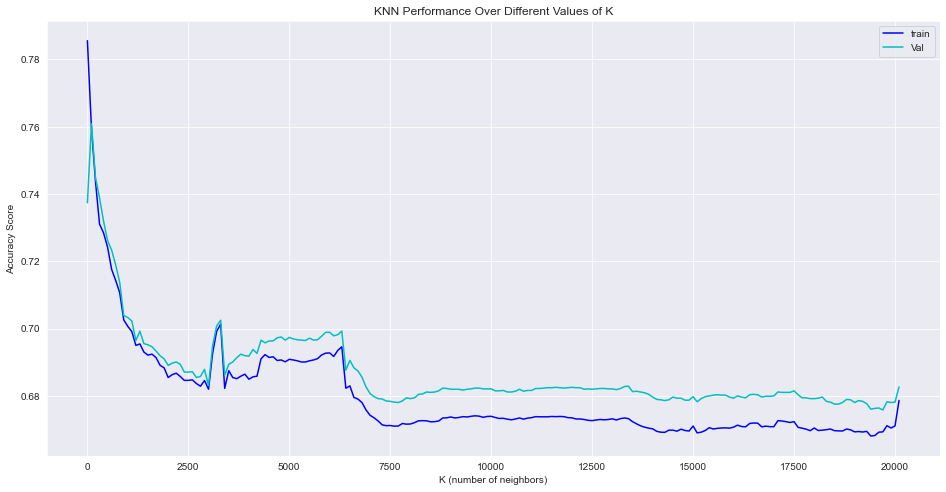

The highest train accuracy occured with a number of neighbors equal to: 101


In [70]:
# Plot train and validation accuracies for each iteration of number of nearest neighbors
plt.figure(figsize=(16,8))
plt.plot(K_values, train_accuracies, label="train", color = 'b')
plt.plot(K_values, test_accuracies, label="Val", color = 'c')
plt.xlabel("K (number of neighbors)")
plt.ylabel("Accuracy Score")
plt.title("KNN Performance Over Different Values of K")
plt.legend()
plt.show()

# Print The k-value with the highest validation accuracy
print(f"The highest train accuracy occured with a number of neighbors equal to: {K_values[test_accuracies.index(max(test_accuracies))]}")

In [71]:
# Empty lists to store iteration results
train_accuracies2 = []
test_accuracies2 = []
K_values2 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainAccuracies2.joblib') & os.path.exists('preRunModels/testAccuracies2.joblib') & os.path.exists('preRunModels/kValues2.joblib')):
    train_accuracies2 = joblib.load('preRunModels/trainAccuracies2.joblib')
    test_accuracies2 = joblib.load('preRunModels/testAccuracies2.joblib')
    K_values2 = joblib.load('preRunModels/kValues2.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # for a range 0-100 in steps of 1
    for k in range(1, 110):

        # Train and fit model with testing number of neighbors
        knnXrfe = KNeighborsClassifier(n_neighbors=k).fit(x1_train, y1_train)

        # Predict model
        y_train_pred = knnXrfe.predict(x1_train)
        y_test_pred = knnXrfe.predict(x1_val)

        # Save model predictions and the relative number of neighbors to lists
        train_accuracies2.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies2.append(accuracy_score(y1_val, y_test_pred))
        K_values2.append(k)

        # Print progress through the loop
        print(f"K={k}/110", end="\r")
            
    # Save the model result lists for loading in the futrure
    joblib.dump(train_accuracies2, 'preRunModels/trainAccuracies2.joblib')
    joblib.dump(test_accuracies2, 'preRunModels/testAccuracies2.joblib')
    joblib.dump(K_values2, 'preRunModels/kValues2.joblib')

Pre-run model will be loaded


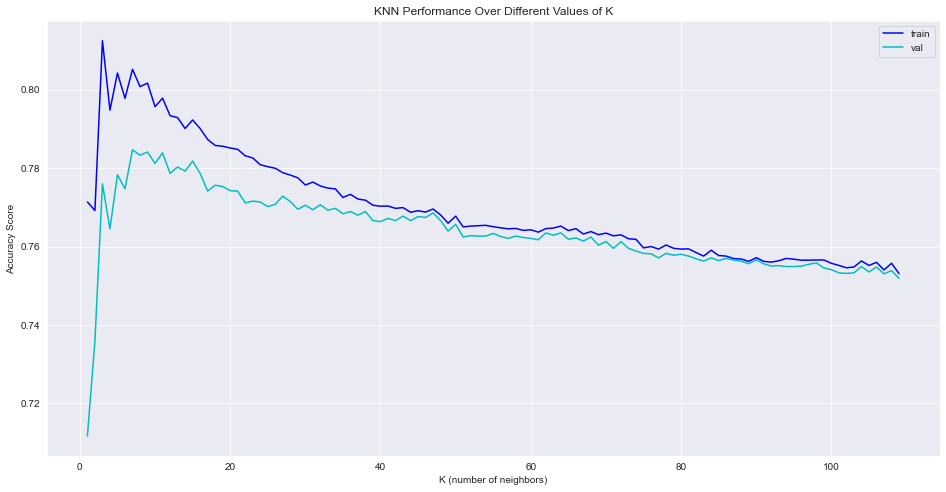

The highest train accuracy occured with a number of neighbors equal to: 7


In [72]:
# Plot train and validation accuracies for each iteration of number of nearest neighbors
plt.figure(figsize=(16,8))
plt.plot(K_values2, train_accuracies2, label="train", color = 'b')
plt.plot(K_values2, test_accuracies2, label="val", color = 'c')
plt.xlabel("K (number of neighbors)")
plt.ylabel("Accuracy Score")
plt.title("KNN Performance Over Different Values of K")
plt.legend()
plt.show()

# Best K-value
kBest = K_values2[test_accuracies2.index(max(test_accuracies2))]

# Print The k-value with the highest validation accuracy
print(f"The highest train accuracy occured with a number of neighbors equal to: {kBest}")

In [73]:
# Start timer
start = time.time()
# Create empty list
timeResultsData = []

# Compile, train, and fit model
knnXrfe = KNeighborsClassifier(n_neighbors = kBest).fit(x1_train, y1_train)

# Predict model
y1_train_pred3 = knnXrfe.predict(x1_train)
y1_val_pred3 = knnXrfe.predict(x1_val)

# Predict scores
trainScore3 = accuracy_score(y1_train, y1_train_pred3)
valScore3 = accuracy_score(y1_val, y1_val_pred3)
precScore3 = precision_score(y1_val, y1_val_pred3)
recScore3 = recall_score(y1_val, y1_val_pred3)

# End Timer
end = time.time()
# Append results to temp list
timeResultsData.append('KNN')
timeResultsData.append(trainScore3)
timeResultsData.append(valScore3)
timeResultsData.append(precScore3)
timeResultsData.append(recScore3)
totalTime3 = round(end - start,2)
timeResultsData.append(totalTime3)
timedResultList.append(timeResultsData)

# Print model results
print(f"Time: {totalTime3} seconds")
print(f"Accuracy score of the train set: {trainScore3}")
print(f"Accuracy score of the validation set: {valScore3}")
print(f"Precision score of the validation set: {precScore3}")
print(f"Recall score of the validation set: {recScore3}")

Time: 2.45 seconds
Accuracy score of the train set: 0.805195450255799
Accuracy score of the validation set: 0.7846795688955847
Precision score of the validation set: 0.7867010067899789
Recall score of the validation set: 0.7801253772927792


The optimized KNN model provided improved results in all cases from the linear models and had a run time that would not cause any issues down the road.

#### Decision Tree:
Decision Trees classify data using a series of if-then-else decisions that create branches leading to a certain class. These can get very complicated for datasets with many features and can easily be built to overfit the data it is trained on. To mitigate complexity and overfitting Decision Tree models are optimized by the number of decisions made (max depth) and the minimum number of like samples needed to create a leaf (min_samples_leafs) which limits the complexity further.

Similar to the techniques used with the KNN optimization we will use a series of loops to find the optimal parameters for our model.

In [74]:
# Range to loop through from 1-20000
minSamples = np.arange(1, 20000)
# Empty lists to store results for graphing
min_value = []
train_accuracies3 = []
test_accuracies3 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainAccuracies3.joblib') & os.path.exists('preRunModels/testAccuracies3.joblib') & os.path.exists('preRunModels/minLeafValues.joblib')):
    train_accuracies3 = joblib.load('preRunModels/trainAccuracies3.joblib')
    test_accuracies3 = joblib.load('preRunModels/testAccuracies3.joblib')
    min_value = joblib.load('preRunModels/minLeafValues.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # For each number from 1-20000....
    for minS in minSamples:
        # Compile, train, and fit the model and data
        dtXrfe = DecisionTreeClassifier(min_samples_leaf = minS, random_state=12)
        dtXrfe.fit(x1_train, y1_train)

        # Predict the data on the model
        y_train_pred = dtXrfe.predict(x1_train)
        y_test_pred = dtXrfe.predict(x1_val)

        # Score the model predictions
        train_accuracies3.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies3.append(accuracy_score(y1_val, y_test_pred))
        min_value.append(minS)
        
        # Print the progress of the loop
        print(f"min samples={minS}/20000", end="\r")
        
    # SAve teh results lists to file
    joblib.dump(train_accuracies3, 'preRunModels/trainAccuracies3.joblib')
    joblib.dump(test_accuracies3, 'preRunModels/testAccuracies3.joblib')
    joblib.dump(min_value, 'preRunModels/minLeafValues.joblib')

Pre-run model will be loaded


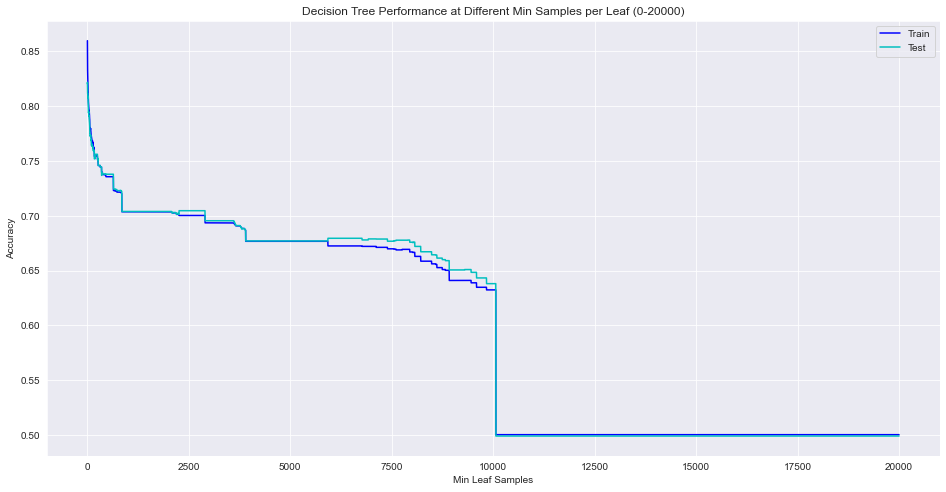

In [75]:
# Plot the performance of the model at each parameter
plt.figure(figsize = (16,8))
plt.plot(min_value, train_accuracies3, label="Train", color = 'b')
plt.plot(min_value, test_accuracies3, label="Test", color = 'c')
plt.xlabel("Min Leaf Samples")
plt.ylabel("Accuracy")
plt.title('Decision Tree Performance at Different Min Samples per Leaf (0-20000)')
plt.legend()
plt.show()

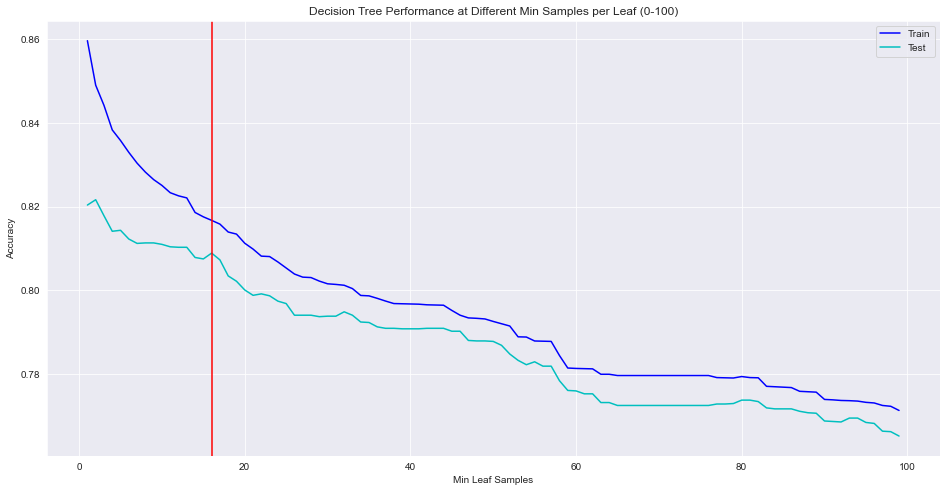

In [76]:
# Plot the performance of the model at each parameter
plt.figure(figsize = (16,8))
plt.plot(min_value[0:99], train_accuracies3[0:99], label="Train", color = 'b')
plt.plot(min_value[0:99], test_accuracies3[0:99], label="Test", color = 'c')
plt.xlabel("Min Leaf Samples")
plt.ylabel("Accuracy")
plt.title('Decision Tree Performance at Different Min Samples per Leaf (0-100)')
plt.legend()
plt.axvline(x=16, color = 'red')
plt.show()

Based on the graph of our results we technically get our highest scores at  a minimum samples of roughly 2. The trade off of using that number tis that our train and validation scores are at their furthest apart which is a major signal of overfitting. The difference between the two accuracy scores is significantly reduced if we move forward to 16 samples and the slight drop in validation accuracy is acceptable.

We'll now loop through different numbers of depths to determine the optimal value with a minimum sample leaf of 16. 

In [77]:
# Range to loop through from 1-50
depths = np.arange(1, 51)
# Empty lists to store results for graphing
depth_value = []
train_accuracies31 = []
test_accuracies31 = []

# For every number of depths....
for depth in depths:
    # Compile, Train, and fit the model and data
    dtXrfe = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = 16, random_state=12)
    dtXrfe.fit(x1_train, y1_train)
    
    # Predict the model results
    y_train_pred = dtXrfe.predict(x1_train)
    y_test_pred = dtXrfe.predict(x1_val)

    # Score the model
    train_accuracies31.append(accuracy_score(y1_train, y_train_pred))
    test_accuracies31.append(accuracy_score(y1_val, y_test_pred))
    depth_value.append(depth)

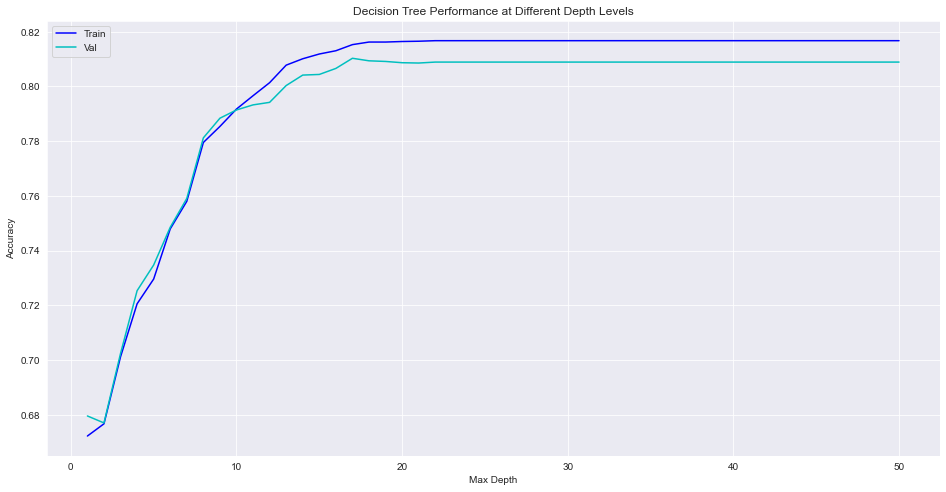

The highest train accuracy occured with a depth equal to: 17


In [78]:
# Plot the train and validation results 
plt.figure(figsize = (16,8))
plt.plot(depth_value, train_accuracies31, label="Train", color = 'b')
plt.plot(depth_value, test_accuracies31, label="Val", color = 'c')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title('Decision Tree Performance at Different Depth Levels')
plt.legend()
plt.show()

# Best depth
dBest = depth_value[test_accuracies31.index(max(test_accuracies31))]

# Print The depth with the highest validation accuracy
print(f"The highest train accuracy occured with a depth equal to: {dBest}")

There is very little overfitting going on so we can choose the depth in which we have the best validations score.

In [79]:
# Start Timer
start = time.time()
# Create empty list for the temp results
timeResultsData = []

# Compile, train, and fit the model
dtXrfe = DecisionTreeClassifier(max_depth = dBest, min_samples_leaf = 16, random_state=12)
dtXrfe.fit(x1_train, y1_train)

# Predict on the model
y1_train_pred4 = dtXrfe.predict(x1_train)
y1_val_pred4 = dtXrfe.predict(x1_val)

# Store the result metrics
trainScore4 = accuracy_score(y1_train, y1_train_pred4)
valScore4 = accuracy_score(y1_val, y1_val_pred4)
precScore4 = precision_score(y1_val, y1_val_pred4)
recScore4 = recall_score(y1_val, y1_val_pred4)

# End timer
end = time.time()
# Add results to temp list
timeResultsData.append('Tree')
timeResultsData.append(trainScore4)
timeResultsData.append(valScore4)
timeResultsData.append(precScore4)
timeResultsData.append(recScore4)
totalTime4 = round(end - start,2)
timeResultsData.append(totalTime4)
# Add temp list to final list
timedResultList.append(timeResultsData)

# Print results
print(f"Time: {totalTime4} seconds")
print(f"Accuracy score of the train set: {trainScore4}")
print(f"Accuracy score of the validation set: {valScore4}")
print(f"Precision score of the validation set: {precScore4}")
print(f"Recall score of the validation set: {recScore4}")

Time: 0.05 seconds
Accuracy score of the train set: 0.8152783986489842
Accuracy score of the validation set: 0.8102908795920732
Precision score of the validation set: 0.8077455048409405
Recall score of the validation set: 0.8135593220338984


These results are by far the best so far for all our metrics. Our train and validation scores are very close indicating very little overfitting and it runs faster than any other model up to this point.

#### Random Forest:
The Random Forest model is simply an ensemble of decision trees (hence the forest) with a randomized subset of the data that is averaged out to help reduce overfitting. The optimization of this type of model follows the same steps as those performed with a decision tree but with an additional hyperparameter that dictactes the number of estimators (decision trees) to perform and average.

In [80]:
# Range to loop through from 1-1000
minSamples = np.arange(1, 1000)
# Empty lists to store results for graphing
min_value41 = []
train_accuracies41 = []
test_accuracies41 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainAccuracies41.joblib') & os.path.exists('preRunModels/testAccuracies41.joblib') & os.path.exists('preRunModels/minLeafValues41.joblib')):
    train_accuracies41 = joblib.load('preRunModels/trainAccuracies41.joblib')
    test_accuracies41 = joblib.load('preRunModels/testAccuracies41.joblib')
    min_value41 = joblib.load('preRunModels/minLeafValues41.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # For each number from 1-1000....
    for minS in minSamples:
        # Compile, train, and fit the model and data
        rfXrfe = RandomForestClassifier(min_samples_leaf = minS, random_state=12)
        rfXrfe.fit(x1_train, y1_train)

        # Predict the data on the model
        y_train_pred = rfXrfe.predict(x1_train)
        y_test_pred = rfXrfe.predict(x1_val)

        # Score the model predictions
        train_accuracies41.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies41.append(accuracy_score(y1_val, y_test_pred))
        min_value41.append(minS)
        
        # Print the progress of the loop
        print(f"min samples={minS}/1000", end="\r")
        
    # SAve teh results lists to file
    joblib.dump(train_accuracies41, 'preRunModels/trainAccuracies41.joblib')
    joblib.dump(test_accuracies41, 'preRunModels/testAccuracies41.joblib')
    joblib.dump(min_value41, 'preRunModels/minLeafValues41.joblib')

Pre-run model will be loaded


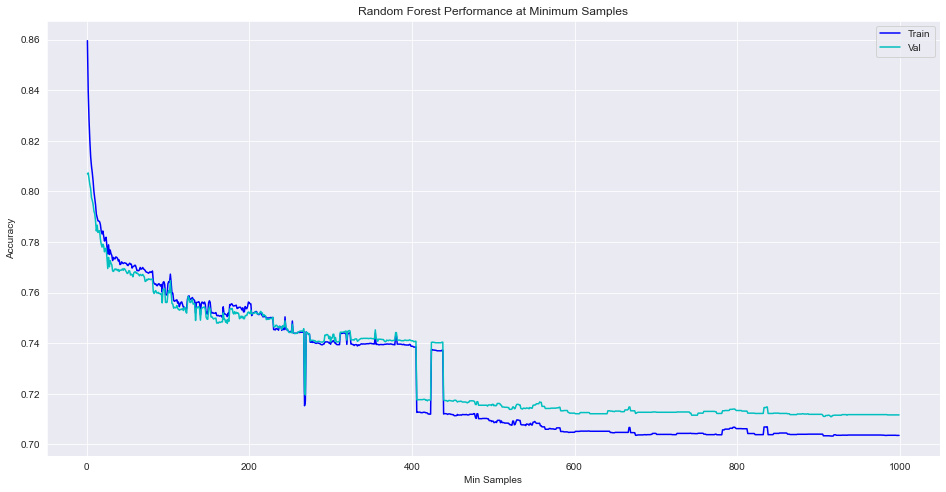

In [81]:
# Plot the train a validation results 
plt.figure(figsize = (16,8))
plt.plot(min_value41, train_accuracies41, label="Train", color = 'b')
plt.plot(min_value41, test_accuracies41, label="Val", color = 'c')
plt.xlabel("Min Samples")
plt.ylabel("Accuracy")
plt.title('Random Forest Performance at Minimum Samples')
plt.legend()
plt.show()

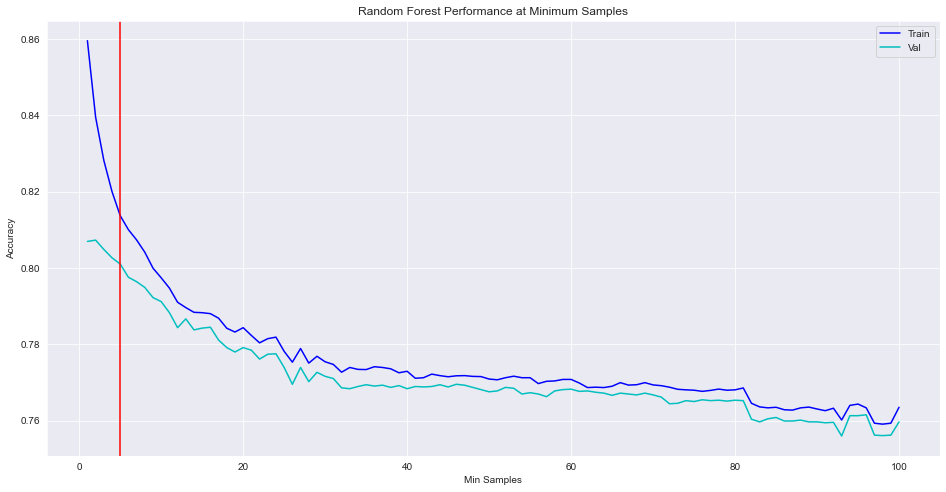

In [82]:
# Plot the train a validation results "zoomed"
plt.figure(figsize = (16,8))
plt.plot(min_value41[0:100], train_accuracies41[0:100], label="Train", color = 'b')
plt.plot(min_value41[0:100], test_accuracies41[0:100], label="Val", color = 'c')
plt.xlabel("Min Samples")
plt.ylabel("Accuracy")
plt.title('Random Forest Performance at Minimum Samples')
plt.legend()
plt.axvline(x = 5, color = 'red')
plt.show()

Based on the graph of our results we technically get our highest scores at a minimum samples of roughly 2. The trade off of using that number though is that our train and validation scores are at their furthest apart which is a major signal of overfitting. That difference between the two scores is significantly reduced if we move forward to 5 samples and the slight drop in validation accuracy is acceptable.

We'll now loop through different numbers of depths to determine the optimal value with a minimum sample leaf of 5. 

In [83]:
# Create range ot loop through
depth2 = np.arange(1, 51)
# Create empty lists
depth2_value = []
train_accuracies5 = []
test_accuracies5 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainAccuracies5.joblib') & os.path.exists('preRunModels/testAccuracies5.joblib') & os.path.exists('preRunModels/depth2Values.joblib')):
    train_accuracies5 = joblib.load('preRunModels/trainAccuracies5.joblib')
    test_accuracies5 = joblib.load('preRunModels/testAccuracies5.joblib')
    depth2_value = joblib.load('preRunModels/depth2Values.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # For each number from 1-50....
    for depth in depth2:
        # compile, train, and fitr the model
        rfXrfe = RandomForestClassifier(min_samples_leaf = 5, max_depth = depth)
        rfXrfe.fit(x1_train, y1_train)

        # Predict the model
        y_train_pred = rfXrfe.predict(x1_train)
        y_test_pred = rfXrfe.predict(x1_val)

        # Save the scores
        train_accuracies5.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies5.append(accuracy_score(y1_val, y_test_pred))
        depth2_value.append(depth)

        # Print the progress
        print(f"depth={depth}/50", end="\r")
        
    # Save model results to be loaded int eh future
    joblib.dump(train_accuracies5, 'preRunModels/trainAccuracies5.joblib')
    joblib.dump(test_accuracies5, 'preRunModels/testAccuracies5.joblib')
    joblib.dump(depth2_value, 'preRunModels/depth2Values.joblib')

Pre-run model will be loaded


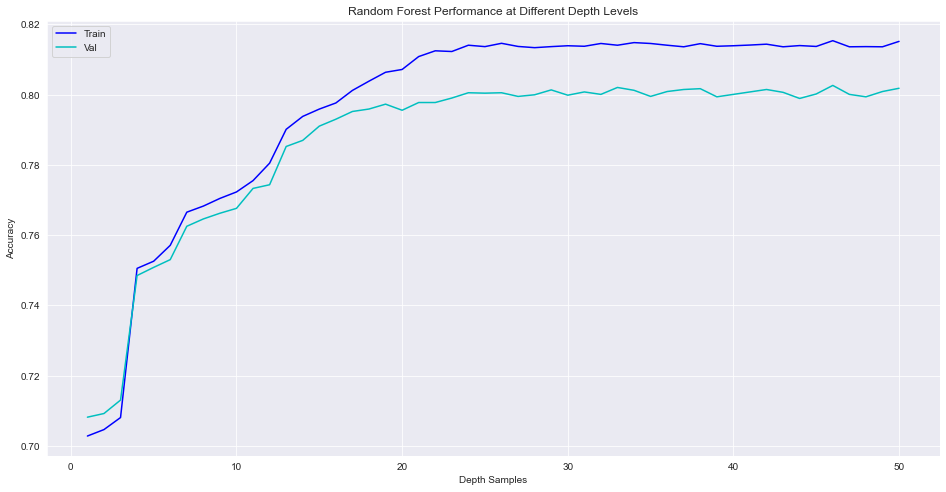

The highest train accuracy occured with a depth equal to: 46


In [84]:
# Plot the traina nd validation results
plt.figure(figsize = (16,8))
plt.plot(depth2_value, train_accuracies5, label="Train", color = 'b')
plt.plot(depth2_value, test_accuracies5, label="Val", color = 'c')
plt.xlabel("Depth Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Random Forest Performance at Different Depth Levels')
plt.show()

# Best depth
dBest2 = depth2_value[test_accuracies5.index(max(test_accuracies5))]

# Print The depth with the highest validation accuracy
print(f"The highest train accuracy occured with a depth equal to: {dBest2}")

We achieve our best results with a max depth of 46. The split between the train and validation sets is below 2% and therefore acceptable.

We'll now loop through different numbers of estimators to determine the optimal value with a minimum sample leaf of 5 and a maximum depth of 46. 

In [85]:
# Range to loop through from 1-100
nEst = np.arange(1, 101)
# Create empty lsits
estimator_value = []
train_accuracies4 = []
test_accuracies4 = []

# Check to see if a pre-run model exists - done to save time when re-running and testing the project
if (os.path.exists('preRunModels/trainAccuracies4.joblib') & os.path.exists('preRunModels/testAccuracies4.joblib') & os.path.exists('preRunModels/nEstimatorValues.joblib')):
    train_accuracies4 = joblib.load('preRunModels/trainAccuracies4.joblib')
    test_accuracies4 = joblib.load('preRunModels/testAccuracies4.joblib')
    estimator_value = joblib.load('preRunModels/nEstimatorValues.joblib')
    print("Pre-run model will be loaded")
# If no pre-run models exist...
else:
    # For each number from 1-100....
    for est in nEst:
        # Compile, train, and fitr the model
        rfXrfe = RandomForestClassifier(n_estimators = est, max_depth = dBest2, min_samples_leaf = 5)
        rfXrfe.fit(x1_train, y1_train)

        # Predict the model
        y_train_pred = rfXrfe.predict(x1_train)
        y_test_pred = rfXrfe.predict(x1_val)

        # Save model scores
        train_accuracies4.append(accuracy_score(y1_train, y_train_pred))
        test_accuracies4.append(accuracy_score(y1_val, y_test_pred))
        estimator_value.append(est)

        # Print progress
        print(f"nEst={est}/100", end="\r")
        
    # Save models to be loaded int eh future
    joblib.dump(train_accuracies4, 'preRunModels/trainAccuracies4.joblib')
    joblib.dump(test_accuracies4, 'preRunModels/testAccuracies4.joblib')
    joblib.dump(estimator_value, 'preRunModels/nEstimatorValues.joblib')

Pre-run model will be loaded


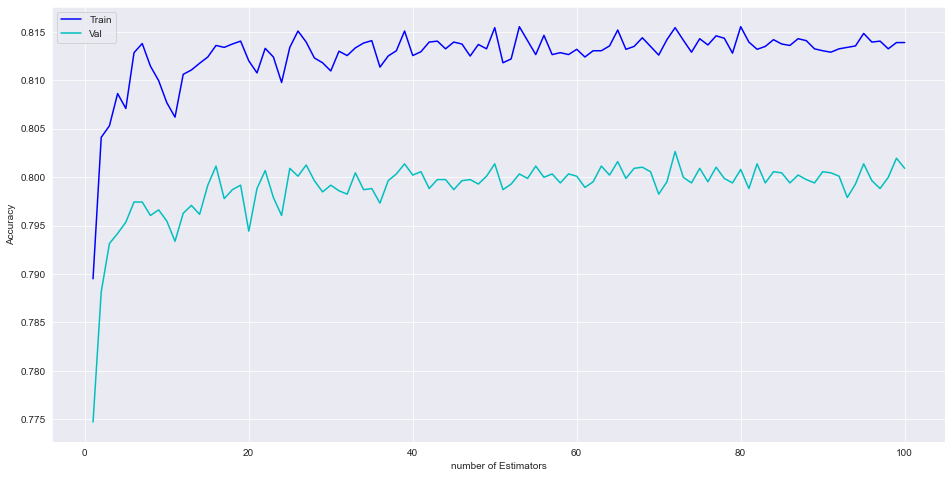

The highest train accuracy occured with a numbewr of estimators equal to: 72


In [86]:
# Plot the traina dn validation results
plt.figure(figsize = (16,8))
plt.plot(estimator_value, train_accuracies4, label="Train", color = 'b')
plt.plot(estimator_value, test_accuracies4, label="Val", color = 'c')
plt.xlabel("number of Estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Best number of estimators
nEstBest = estimator_value[test_accuracies4.index(max(test_accuracies4))]

# Print The number of estimators with the highest validation accuracy
print(f"The highest train accuracy occured with a numbewr of estimators equal to: {nEstBest}")

Again we are seeing minor differences between our train and validation sets sow e can go with the number of estimators resulting int he best accuracy score. 

In [87]:
# Start timer
start = time.time()
# Create empty list to save temp data
timeResultsData = []

# Compile, Train, Fit model
rfXrfe = RandomForestClassifier(n_estimators = nEstBest, max_depth = dBest2, min_samples_leaf = 5, random_state=12)
rfXrfe.fit(x1_train, y1_train)

# Predict model
y1_train_pred5 = rfXrfe.predict(x1_train)
y1_val_pred5 = rfXrfe.predict(x1_val)

# Calculate model scores
trainScore5 = accuracy_score(y1_train, y1_train_pred5)
valScore5 = accuracy_score(y1_val, y1_val_pred5)
precScore5 = precision_score(y1_val, y1_val_pred5)
recScore5 = recall_score(y1_val, y1_val_pred5)

# End timer
end = time.time()
# Save model scores to temp list
timeResultsData.append('Forest')
timeResultsData.append(trainScore5)
timeResultsData.append(valScore5)
timeResultsData.append(precScore5)
timeResultsData.append(recScore5)
totalTime5 = round(end - start,2)
timeResultsData.append(totalTime5)
# Save temp list to final list
timedResultList.append(timeResultsData)

# Print scores
print(f"Time: {totalTime5} seconds")
print(f"Accuracy score of the train set: {trainScore5}")
print(f"Accuracy score of the validation set: {valScore5}")
print(f"Precision score of the validation set: {precScore5}")
print(f"Recall score of the validation set: {recScore5}")

Time: 0.76 seconds
Accuracy score of the train set: 0.813589628967367
Accuracy score of the validation set: 0.8000927106269556
Precision score of the validation set: 0.7928765880217786
Recall score of the validation set: 0.8114697004875784


The Random Forest performed relatively well and resulted in scores very similar to that of our stand alone Decision Tree. There was a slight drop in precision which could be due to the fast we are taking an average.

#### Bagged Model with Voting:
At this point the KNN and Decision Tree were our best performing stand alone models. We can employ a voting classifier function to take both of those models and create an ensemble. This will fit a random subset of our data to each type model and then average the results similar to the process that occurs with a Random Forrest. This is done with the intention of reducing overfitting. We will be giving the Decision Tree model more weight in this ensemble as it performed better on its own.

In [88]:
# Create bag of models to ensemble
estimatorBag = [
    ('DT', dtXrfe),
    ('KNN', knnXrfe)]

In [89]:
# Start timer
start = time.time()
# Create empty list to save temp data
timeResultsData = []

# Compile, Train, Fit model
bagXrfe = VotingClassifier(estimators=estimatorBag, voting="soft", weights=[3,2])
bagXrfe.fit(x1_train, y1_train)

# Predict model
y1_train_pred6 = bagXrfe.predict(x1_train)
y1_val_pred6 = bagXrfe.predict(x1_val)

# Calculate model scores
trainScore6 = accuracy_score(y1_train, y1_train_pred6)
valScore6 = accuracy_score(y1_val, y1_val_pred6)
precScore6 = precision_score(y1_val, y1_val_pred6)
recScore6 = recall_score(y1_val, y1_val_pred6)

# End timer
end = time.time()
# Save model scores to temp list
timeResultsData.append('KNN Tree')
timeResultsData.append(trainScore6)
timeResultsData.append(valScore6)
timeResultsData.append(precScore6)
timeResultsData.append(recScore6)
totalTime6 = round(end - start,2)
timeResultsData.append(totalTime6)
# Save temp list to final list
timedResultList.append(timeResultsData)

# Print scores
print(f"Time: {totalTime6} seconds")
print(f"Accuracy score of the train set: {trainScore6}")
print(f"Accuracy score of the validation set: {valScore6}")
print(f"Precision score of the validation set: {precScore6}")
print(f"Recall score of the validation set: {recScore6}")

Time: 1.9 seconds
Accuracy score of the train set: 0.8236229076640341
Accuracy score of the validation set: 0.8112179858616294
Precision score of the validation set: 0.8045950864422202
Recall score of the validation set: 0.8212212677037382


As with the other model that involved a Decision Tree this model performed well in comparison to the others in this project with very little overfitting.

---
### Results and Summary:
Below is a table summarizing all the result metrics and run times for each of the models tested in this project. There was a significant increase in performance from the linear models to the more complex classifiers. The required benchmarks for the project was an accuracy score of 80% or higher with an emphasis on recall yo ensure that no potential recruitment targets are missed. The Decision Tree, Random Forest, and KNN/Decision Tree ensemble reached the accuracy score benchmark and all ran very quickly. Of those three the KNN Tree model correctly identified the most recruitment targets as shown by its recall score. 

In [90]:
# Compile new dataframe from final score list
timeDF = pd.DataFrame(timedResultList)
# Rename columns
timeDF.columns = ['Model Type', 'Train Accuracy', 'Validation Accuracy', 'Precision', 'Recall', 'Time (s)']
timeDF

,Model Type,Train Accuracy,Validation Accuracy,Precision,Recall,Time (s)
0,Log Reg,0.738191,0.738672,0.731185,0.753425,0.65
1,SVC,0.759698,0.752926,0.746767,0.764105,188.88
2,KNN,0.805195,0.784680,0.786701,0.780125,2.45
3,Tree,0.815278,0.810291,0.807746,0.813559,0.05
4,Forest,0.813590,0.800093,0.792877,0.811470,0.76
5,KNN Tree,0.823623,0.811218,0.804595,0.821221,1.90


Displaying the results in a confusion metric breaks down the distribution true and predicted results. The KNN Tree was miss-classifying 18% of the recruitment targets.

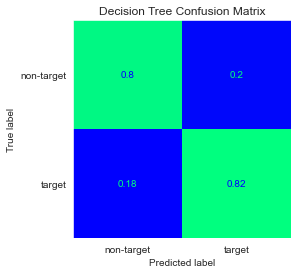

In [91]:
# Change style for aesthetics
sns.set_style('dark')
# Set labels
labels = ['non-target', 'target']
# Plot confusion matrix for KNN Tree
confMatrix = plot_confusion_matrix(bagXrfe, x1_val ,y1_val, cmap = 'winter', colorbar = False, display_labels= labels, normalize = 'true')
plt.title('Decision Tree Confusion Matrix')
plt.show(confMatrix)

---
### Applying the Model
We were given a preliminary dataset of enrollees that the recruitment team needed us to label with who was a target and who was not. They require the `enrollee_id` and a ranking of which targets should be prioritized. To do this we must first remove the `enrollee_id` as it was not an included feature in the model then feed the unclassified dataset into our chosen model, and finally producing a ranked table of targets. The target priority ranking will be based on the model's confidence in the probability that each enrollee is truthfully a target.

In [92]:
# Create function to process and output the final target lsits in csv
def targetList(model, dataset):
    # Drop enrollee_id column
    predXrfeSub = dataset.drop(['enrollee_id'], axis = 1)
    # Predict on temp table -  get classes and their probabilities
    testTargets = model.predict(predXrfeSub)
    predictProba = model.predict_proba(predXrfeSub)
    # Add classes and probabilities to dataset
    dataset.insert(1, 'Target', testTargets)
    dataset.insert(2, 'Target Probability', predictProba[:,-1])
    # Trim dataset of unwanted columns
    recruitmentTargets = dataset[['enrollee_id', 'Target', 'Target Probability']].loc[(dataset['Target'] == 1)]
    # Sort by probability
    recruitmentTargets.sort_values(by='Target Probability', ascending=False, inplace=True)
    # Save to csv
    recruitmentTargets.to_csv(index = False)
    # Print number of target classes
    print(f"There are: {dataset['Target'].value_counts()[1]} recruitment targets out of {dataset.shape[0]} enrollees.")
    display(recruitmentTargets)

In [93]:
targetList(bagXrfe, hrPred)

There are: 1625 recruitment targets out of 2129 enrollees.


,enrollee_id,Target,Target Probability
1245,12505,1.0,1.000000
536,139,1.0,1.000000
526,20833,1.0,1.000000
1819,16079,1.0,1.000000
528,9707,1.0,1.000000
...,...,...,...
1214,22045,1.0,0.506767
1341,22870,1.0,0.506767
1438,17952,1.0,0.505263
1421,29417,1.0,0.505263


By apply our model to the list of enrollees we are able to produce a ranked list for the recruitment team in less than a second. These models will never output a perfect list of targets but the efficiency it provides outweighs the downsides.

### Conclusion
Throughout this project many different model types and configurations were tested to produce a KNN / Decision Tree ensemble model that will correctly identify recruitment targets with an accuracy of 82%. This model runs and produces a ranked list in much less time than a traditional manual strategy would while using less resources. This increase in efficiency will allow the recruiting department to focus their time and energy on reaching out to and interviewing the enrollees who are the most likely to change jobs. This project demonstrates how data science and machine learning can be used to support and augment departments throughout a company's structure with the goal of increasing efficiency by automating menial tasks to save time and free up resources.